## Import Packages

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

# datetime for manipulating date and time
import datetime

# statsmodels for autoregressive models
import statsmodels.tsa.ar_model as AutoReg

# scipy
import scipy.stats as stats

random.seed(2)

## Load and clean data

### Patient data

#### Load

In [2]:
df = pd.read_csv("../../data/raw/scores.csv")
df.head()

number  days  gender    age  afftype  melanch  inpatient    edu  \
0  condition_1    11       2  35-39      2.0      2.0        2.0   6-10   
1  condition_2    18       2  40-44      1.0      2.0        2.0   6-10   
2  condition_3    13       1  45-49      2.0      2.0        2.0   6-10   
3  condition_4    13       2  25-29      2.0      2.0        2.0  11-15   
4  condition_5    13       2  50-54      2.0      2.0        2.0  11-15   

   marriage  work  madrs1  madrs2  
0       1.0   2.0    19.0    19.0  
1       2.0   2.0    24.0    11.0  
2       2.0   2.0    24.0    25.0  
3       1.0   1.0    20.0    16.0  
4       2.0   2.0    26.0    26.0

#### Clean

In [3]:
# Change data types of columns to correct types
for col in ['gender','age','edu','afftype','melanch','inpatient','marriage','work']:
    df[col] = df[col].astype('category')

for col in ['days','madrs1','madrs2']:
    df[col] = df[col].astype('float64')

# Replace blanks and NaNs with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

#### Get frequencies of features

In [4]:
features = ['days', 'gender', 'age', 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work', 'madrs1', 'madrs2']

# Find missing values in each column
for col in features:
    print(col, df[col].isna().sum())

days 0
gender 0
age 0
afftype 32
melanch 35
inpatient 32
edu 33
marriage 32
work 32
madrs1 32
madrs2 32


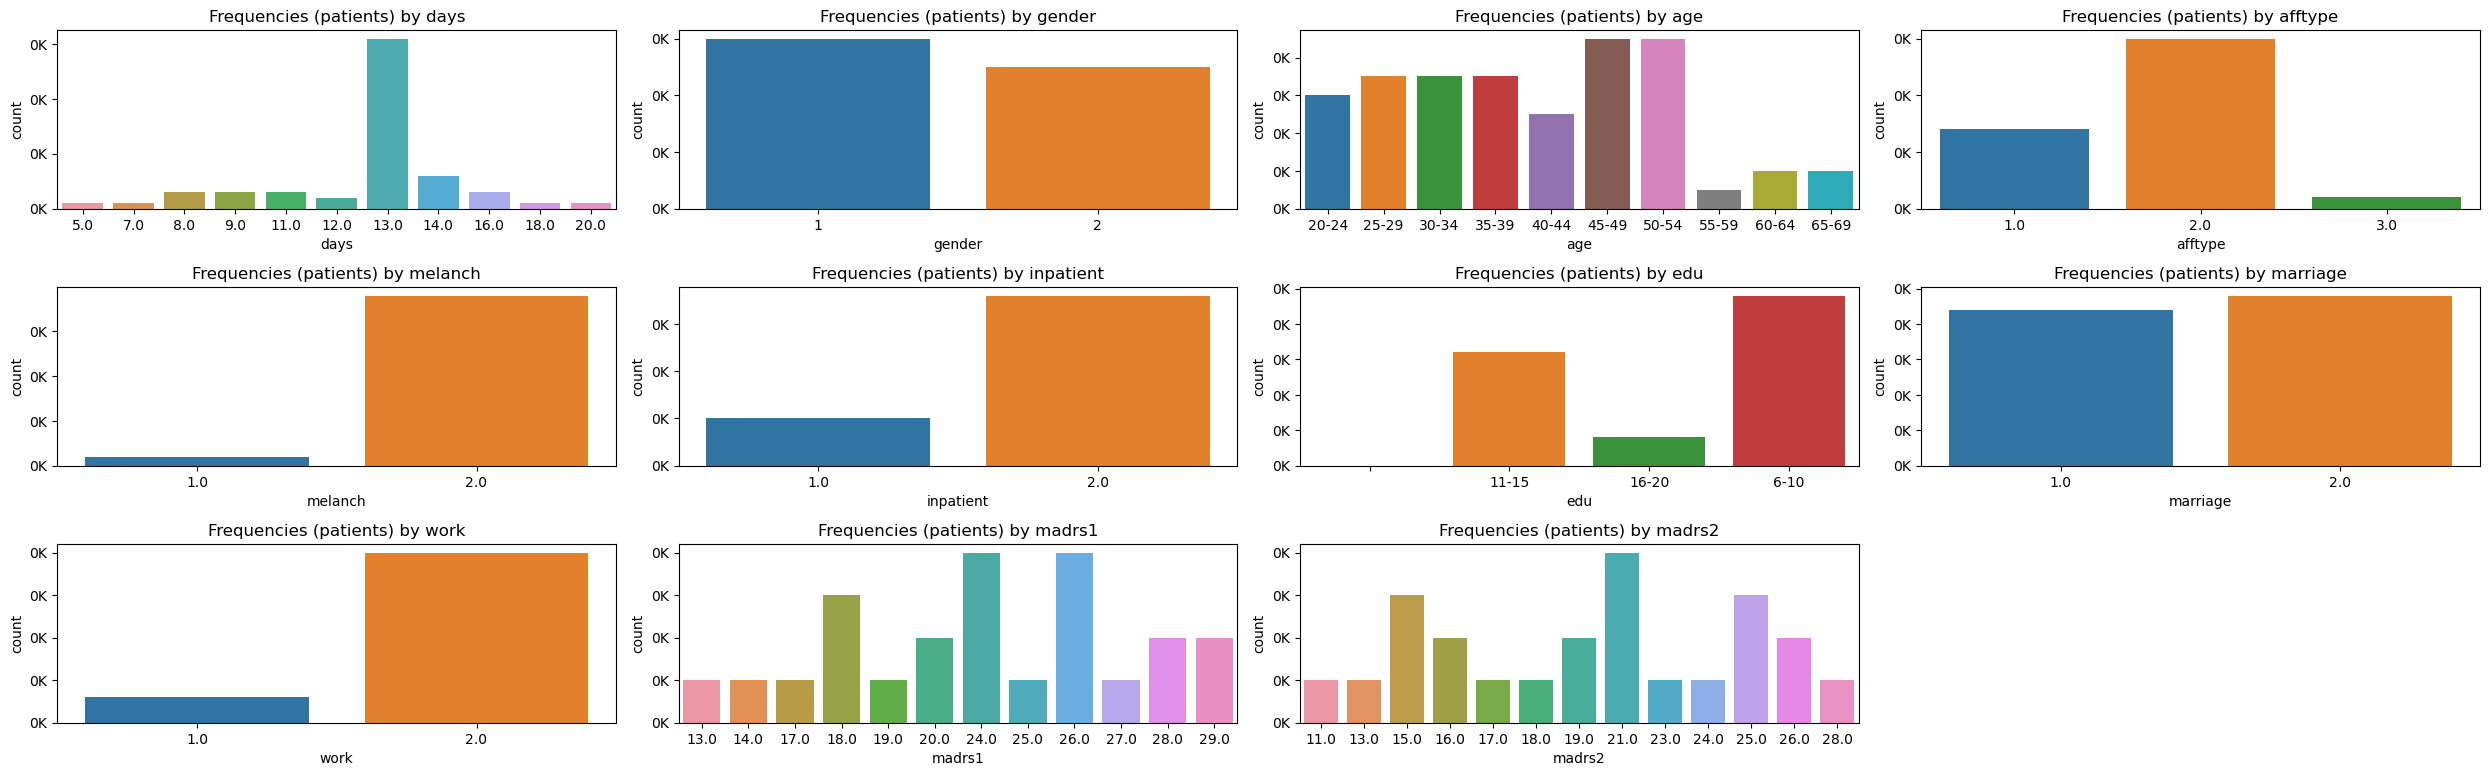

In [5]:
def plot_frequencies(data, features, num_rows, num_cols, figsize, title):
    """
    Plots frequencies of categorical features in a dataset.
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.countplot(data=data, x=feature, ax=axes[i])
        axes[i].set_title(title + feature)
        axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}K'.format(x * 1e-3)))  # Format y-axis labels in thousands

    if len(features) < num_rows * num_cols:
        for j in range(len(features), num_rows * num_cols):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_frequencies(df, features, 4, 4, (25, 10), title="Frequencies (patients) by ")

#### Bucket MADRS scores and afftype to fewer categories

Some observations/notes:
- afftype will have to be grouped as afftype=3 only has N=1
- MADRS is traditionally classified as normal, mild, moderate or severe based on the scores (0-6, 7-19, 20-34, 35-60 respectively)

In [6]:
# Function to classify MADRS scores
def classify_depression(madrs):
    if madrs < 7:
        return "Normal"
    elif madrs < 20:
        return "Mild"
    elif madrs < 35:
        return "Moderate"
    else:
        return "Severe"

# Create MADRS1_class variable
df['madrs1_grouped'] = df.apply(lambda row: classify_depression(row['madrs1']) if not row['number'].startswith('control') else "Normal", axis=1)

# Create MADRS2_class variable
df['madrs2_grouped'] = df.apply(lambda row: classify_depression(row['madrs2']) if not row['number'].startswith('control') else "Normal", axis=1)

# Create a new afftype_grouped variable
def classify_afftype(afftype):
    if afftype in [1, 3]:
        return 'Bipolar'
    elif afftype == 2:
        return 'Unipolar'
    else:
        return 'Normal'
    
df['afftype_grouped'] = df.apply(lambda row: classify_afftype(row['afftype']), axis=1)

# Display the updated DataFrame
df[['number', 'madrs1', 'madrs1_grouped', 'madrs2', 'madrs2_grouped', 'afftype_grouped']].head()

number  madrs1 madrs1_grouped  madrs2 madrs2_grouped afftype_grouped
0  condition_1    19.0           Mild    19.0           Mild        Unipolar
1  condition_2    24.0       Moderate    11.0           Mild         Bipolar
2  condition_3    24.0       Moderate    25.0       Moderate        Unipolar
3  condition_4    20.0       Moderate    16.0           Mild        Unipolar
4  condition_5    26.0       Moderate    26.0       Moderate        Unipolar

In [7]:
# Make side by side crosstabs
pd.crosstab(
    df['madrs1_grouped'],
    df['afftype_grouped'],
    margins=True,
    margins_name='Total'
)

afftype_grouped  Bipolar  Normal  Unipolar  Total
madrs1_grouped                                   
Mild                   3       0         4      7
Moderate               5       0        11     16
Normal                 0      32         0     32
Total                  8      32        15     55

In [8]:
pd.crosstab(
    df['madrs2_grouped'],
    df['afftype_grouped'],
    margins=True,
    margins_name='Total'
)

afftype_grouped  Bipolar  Normal  Unipolar  Total
madrs2_grouped                                   
Mild                   5       0         6     11
Moderate               3       0         9     12
Normal                 0      32         0     32
Total                  8      32        15     55

#### Create composite class based on madrs_grouped and afftype_grouped

madrs2 appears to be a better label than madrs1 due to a more even distribution of values between the different classes. Also, given that the madrs2 is measured after all the motor recordings temporally it makes sense to use this over madrs1

In [9]:
# Create new composite classification
def classify(madrs_grouped, afftype_grouped):
    if afftype_grouped == "Normal":
        return "Normal"
    elif afftype_grouped == "Unipolar" and madrs_grouped == "Mild":
        return "Unipolar - Mild"
    elif afftype_grouped == "Unipolar" and madrs_grouped == "Moderate":
        return "Unipolar - Moderate"
    elif afftype_grouped == "Bipolar" and madrs_grouped == "Mild":
        return "Bipolar - Mild"
    else:
        return "Bipolar - Moderate"

df['madrs2_afftype'] = df.apply(lambda row: classify(row['madrs2_grouped'], row['afftype_grouped']), axis=1)
df[['number', 'madrs1', 'madrs1_grouped', 'madrs2', 'madrs2_grouped', 'afftype_grouped', 'madrs2_afftype']].head()

number  madrs1 madrs1_grouped  madrs2 madrs2_grouped afftype_grouped  \
0  condition_1    19.0           Mild    19.0           Mild        Unipolar   
1  condition_2    24.0       Moderate    11.0           Mild         Bipolar   
2  condition_3    24.0       Moderate    25.0       Moderate        Unipolar   
3  condition_4    20.0       Moderate    16.0           Mild        Unipolar   
4  condition_5    26.0       Moderate    26.0       Moderate        Unipolar   

        madrs2_afftype  
0      Unipolar - Mild  
1       Bipolar - Mild  
2  Unipolar - Moderate  
3      Unipolar - Mild  
4  Unipolar - Moderate

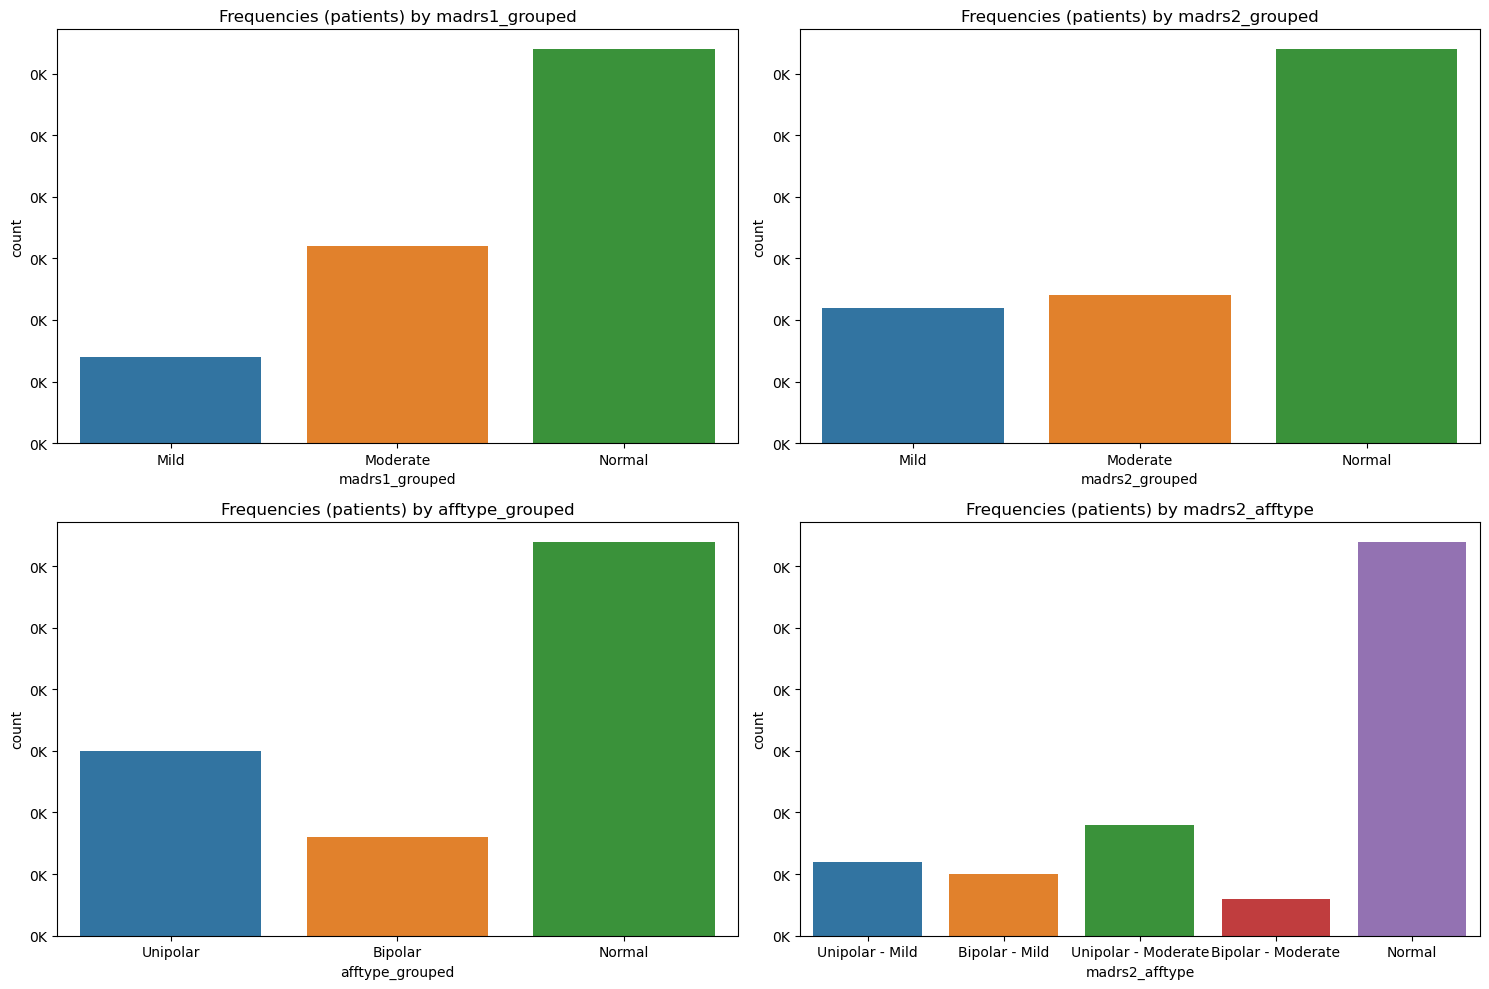

In [10]:
plot_frequencies(df, ['madrs1_grouped', 'madrs2_grouped', 'afftype_grouped', 'madrs2_afftype'], 2, 2, (15, 10), title="Frequencies (patients) by ")

### Load time series motor activity data

In [11]:
import os
import pandas as pd

def consolidate_csv_files(condition_directory, control_directory):
    # Create an empty DataFrame to store the consolidated data
    df_motor_raw = pd.DataFrame()

    # Get a list of all files in the condition directory
    condition_files = os.listdir(condition_directory)

    # Iterate over each condition file
    for condition_file in condition_files:
        # Extract the number from the filename
        number = condition_file.replace('condition_', '').replace('.csv', '')
        # Read the condition file into a DataFrame
        condition_data = pd.read_csv(os.path.join(condition_directory, condition_file))
        # Add the 'number' column to the condition data
        condition_data['number'] = 'condition_' + str(number)
        # Append the condition data to the consolidated data
        df_motor_raw = pd.concat([df_motor_raw, condition_data], ignore_index=True)

    # Get a list of all files in the control directory
    control_files = os.listdir(control_directory)

    # Iterate over each control file
    for control_file in control_files:
        # Extract the number from the filename
        number = control_file.replace('control_', '').replace('.csv', '')
        # Read the control file into a DataFrame
        control_data = pd.read_csv(os.path.join(control_directory, control_file))
        # Add the 'number' column to the control data
        control_data['number'] = 'control_' + str(number)
        # Append the control data to the consolidated data
        df_motor_raw = pd.concat([df_motor_raw, control_data], ignore_index=True)

    # Change timestamp and date to datetime format
    df_motor_raw['timestamp'] = pd.to_datetime(df_motor_raw['timestamp'])
    df_motor_raw['date'] = pd.to_datetime(df_motor_raw['date'])

    # Sort by number and timestamp
    df_motor_raw = df_motor_raw.sort_values(by=['number', 'timestamp'])

    # Reindex
    df_motor_raw = df_motor_raw.reset_index(drop=True)

    return df_motor_raw

df_motor_raw = consolidate_csv_files('../../data/raw/condition', '../../data/raw/control')

### Merge patient-level and time-series data

In [12]:
# Merge the patient-level data with the time-series data
df_merged = pd.merge(df, df_motor_raw, on=['number'])
df_merged.head()

number  days gender    age afftype melanch inpatient   edu marriage  \
0  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
1  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
2  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
3  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
4  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   

  work  madrs1  madrs2 madrs1_grouped madrs2_grouped afftype_grouped  \
0  2.0    19.0    19.0           Mild           Mild        Unipolar   
1  2.0    19.0    19.0           Mild           Mild        Unipolar   
2  2.0    19.0    19.0           Mild           Mild        Unipolar   
3  2.0    19.0    19.0           Mild           Mild        Unipolar   
4  2.0    19.0    19.0           Mild           Mild        Unipolar   

    madrs2_afftype           timestamp       date  activity  
0  Unipolar - Mild 2003-05-07 12:00:00 2003-05-07         0  
1  Unipolar - Mild 2003-05-07 12:01:00 2003-05-07       143  
2  Unipolar - Mild 2003-05-07 12:02:00 2003-05-07         0  
3  Unipolar - Mild 2003-05-07 12:03:00 2003-05-07        20  
4  Unipolar - Mild 2003-05-07 12:04:00 2003-05-07       166

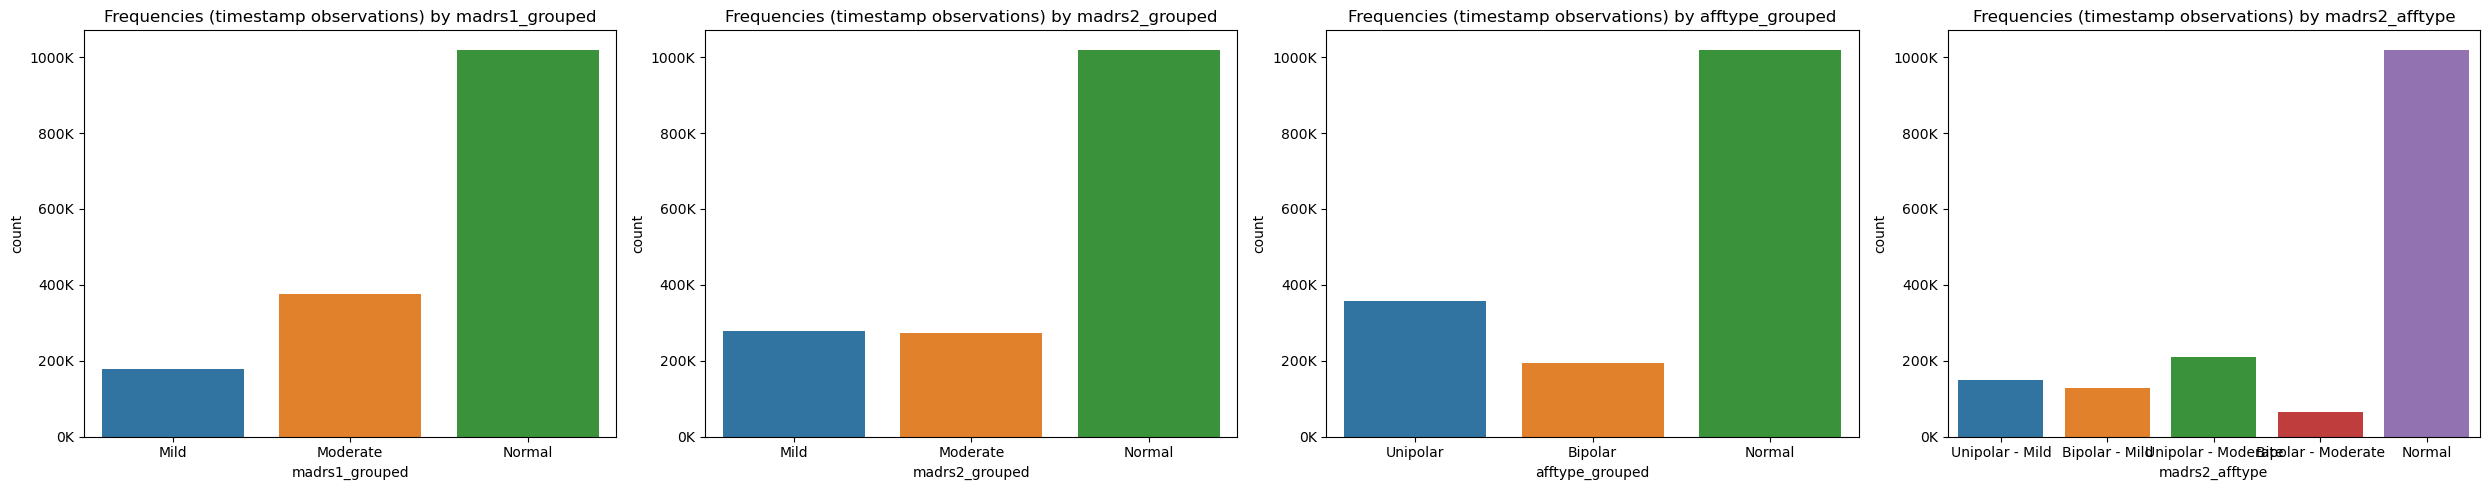

In [13]:
plot_frequencies(df_merged, ['madrs1_grouped', 'madrs2_grouped', 'afftype_grouped', 'madrs2_afftype'], 1, 4, (25, 5), title="Frequencies (timestamp observations) by ")

The team agrees that madrs2_grouped will be used as the outcome variable

### Remove rows with invalid timestamps

In [14]:
# Calculate hour, day, month, and year
df_merged['minute_of_day'] = df_merged['timestamp'].dt.hour * 60 + df_merged['timestamp'].dt.minute
df_merged['minute'] = df_merged['timestamp'].dt.minute
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day'] = df_merged['timestamp'].dt.day
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek
df_merged['week_of_year'] = df_merged['timestamp'].dt.isocalendar().week
df_merged['month'] = df_merged['timestamp'].dt.month
df_merged['year'] = df_merged['timestamp'].dt.year

# Calculate minute after first timestamp
df_merged['minute_after_first'] = df_merged.groupby('number')['timestamp'].rank(method='first')

# Calculate hour after first timestamp
df_merged['hour_after_first'] = df_merged['minute_after_first'] // 60

# Calculate day after first timestamp
df_merged['day_after_first'] = df_merged['hour_after_first'] // 24

df_merged.head()

number  days gender    age afftype melanch inpatient   edu marriage  \
0  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
1  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
2  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
3  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   
4  condition_1  11.0      2  35-39     2.0     2.0       2.0  6-10      1.0   

  work  ...  minute  hour day day_of_week week_of_year month  year  \
0  2.0  ...       0    12   7           2           19     5  2003   
1  2.0  ...       1    12   7           2           19     5  2003   
2  2.0  ...       2    12   7           2           19     5  2003   
3  2.0  ...       3    12   7           2           19     5  2003   
4  2.0  ...       4    12   7           2           19     5  2003   

  minute_after_first  hour_after_first  day_after_first  
0                1.0               0.0              0.0  
1                2.0               0.0              0.0  
2                3.0               0.0              0.0  
3                4.0               0.0              0.0  
4                5.0               0.0              0.0  

[5 rows x 30 columns]

In [15]:
# Remove rows where day_after_first is greater than 'days'
print(df_merged.shape)
df_merged = df_merged[df_merged['day_after_first'] <= df_merged['days']]
print(df_merged.shape)

(1571706, 30)
(1077065, 30)


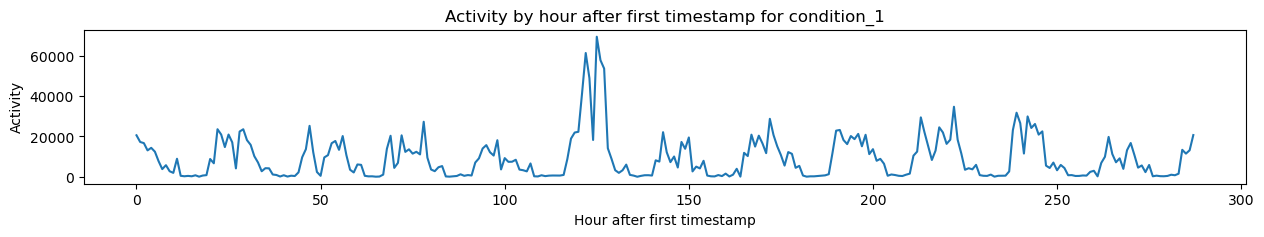

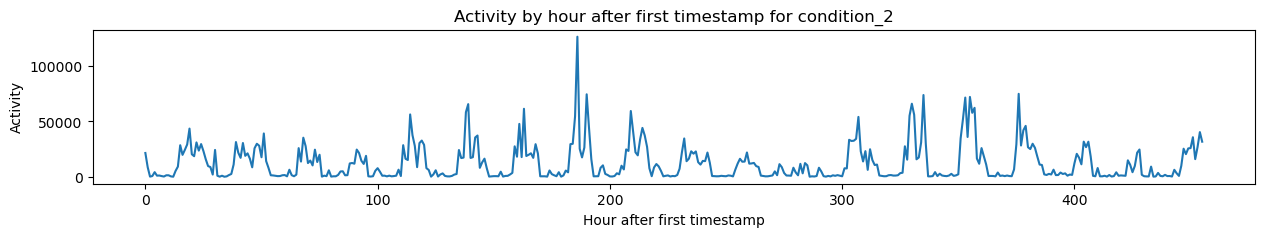

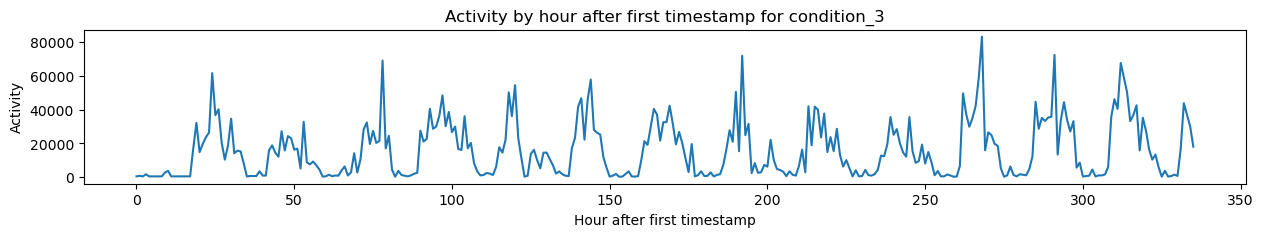

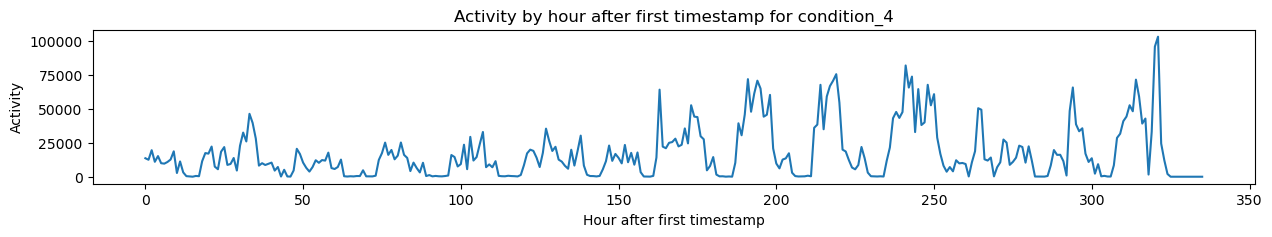

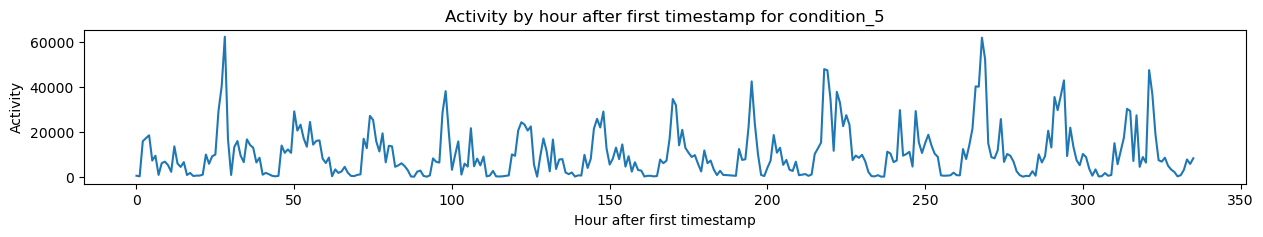

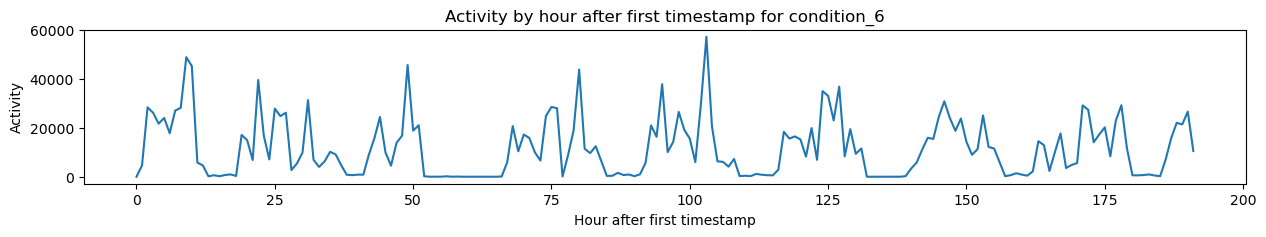

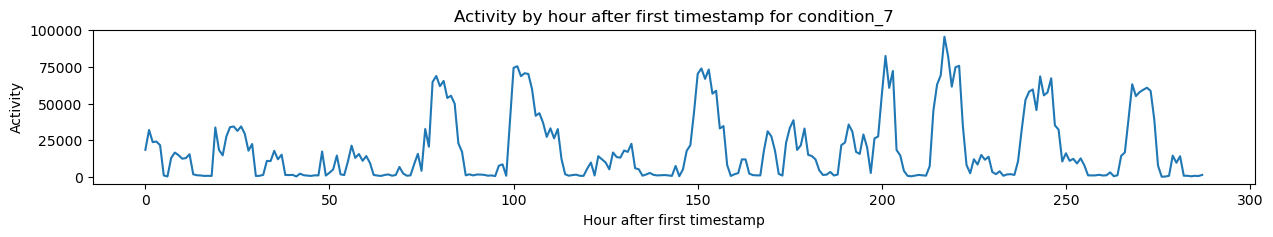

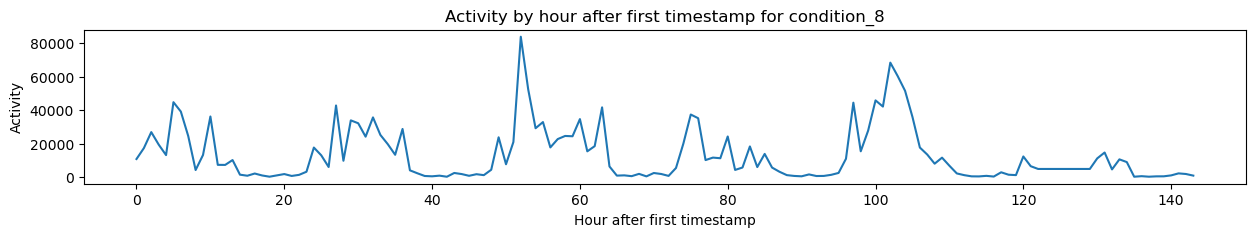

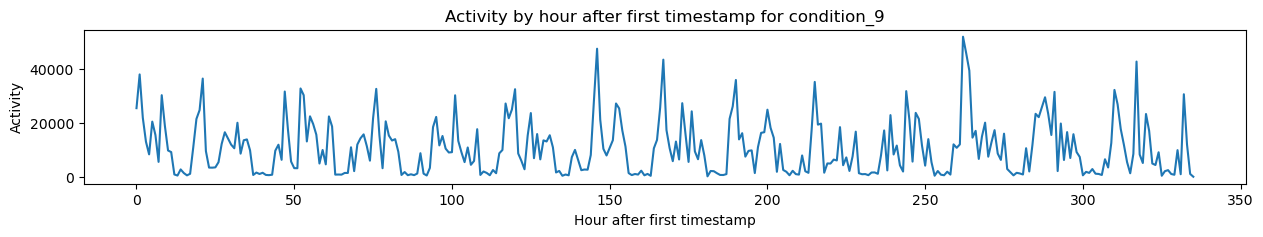

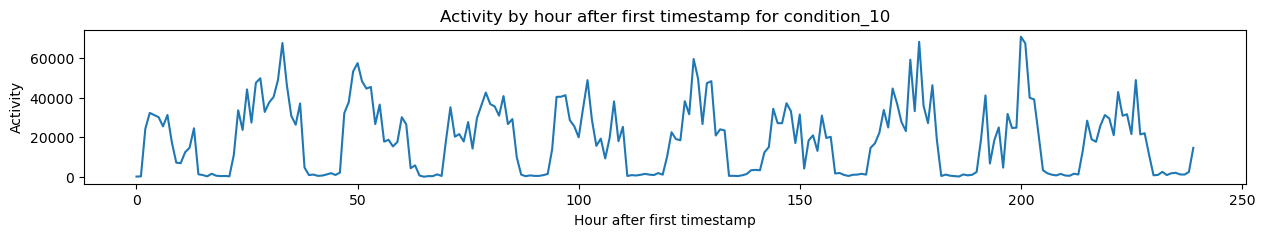

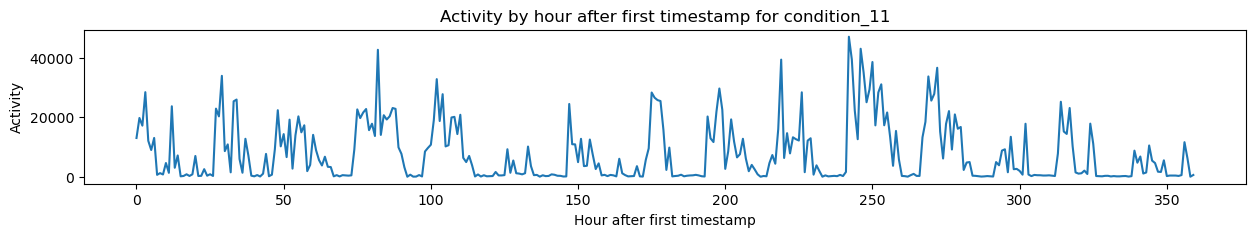

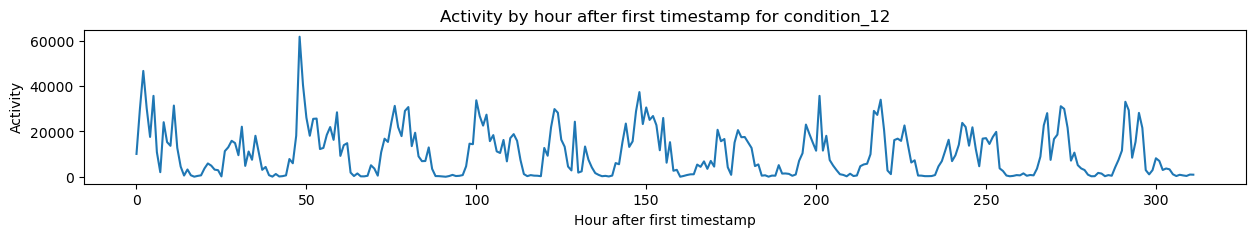

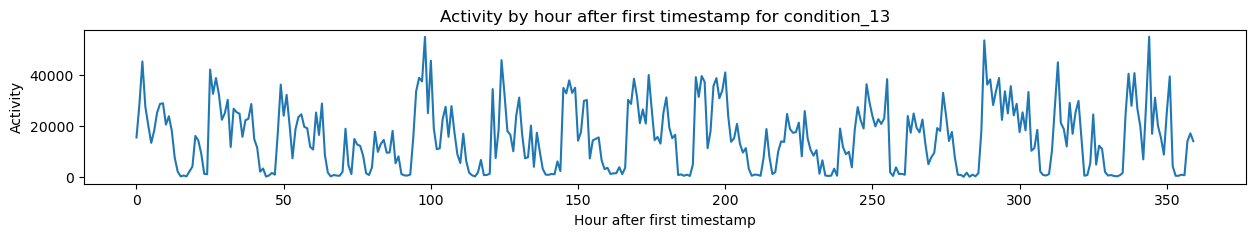

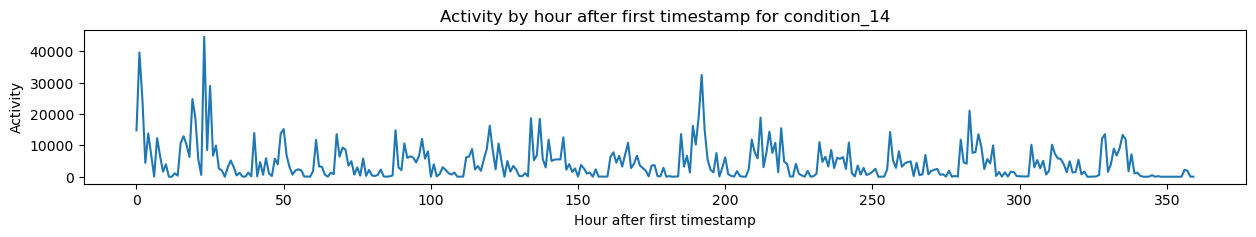

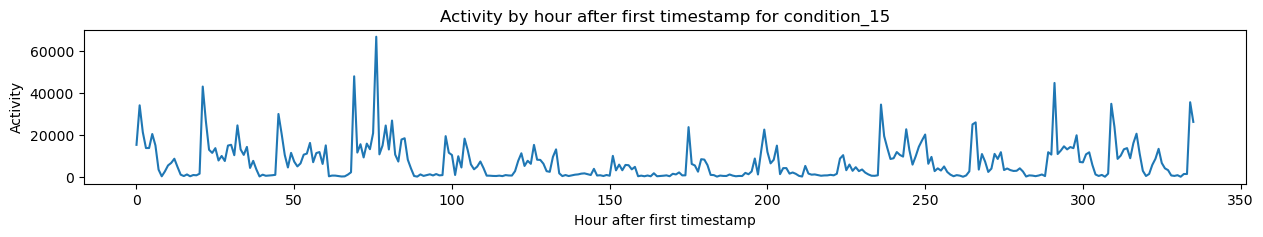

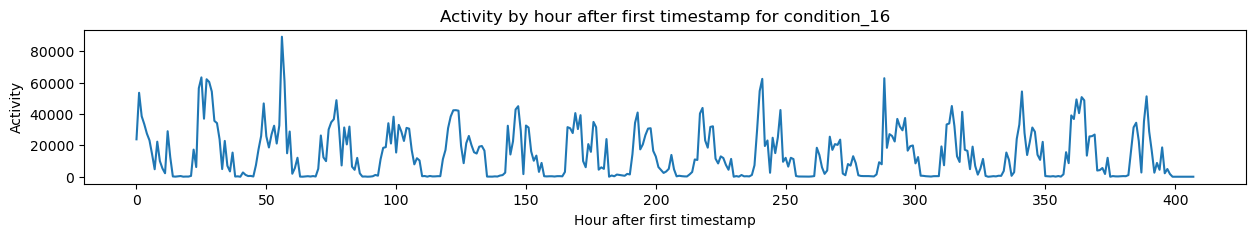

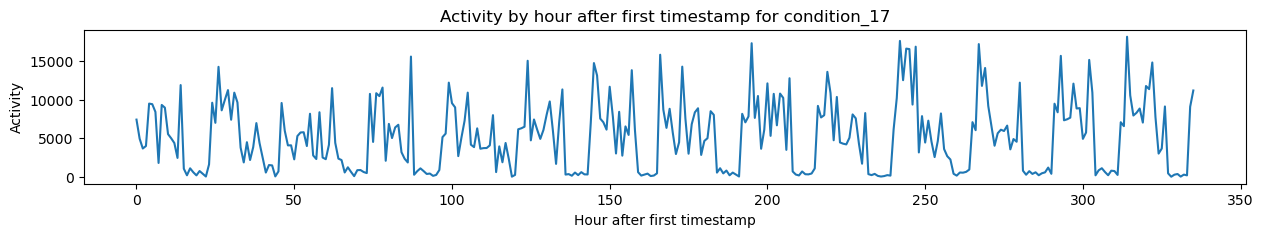

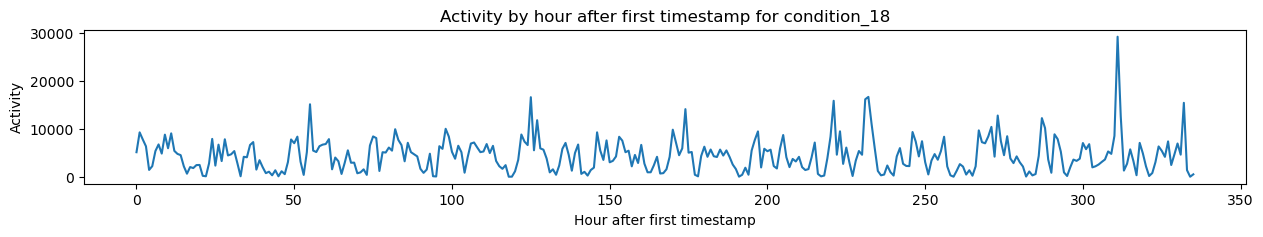

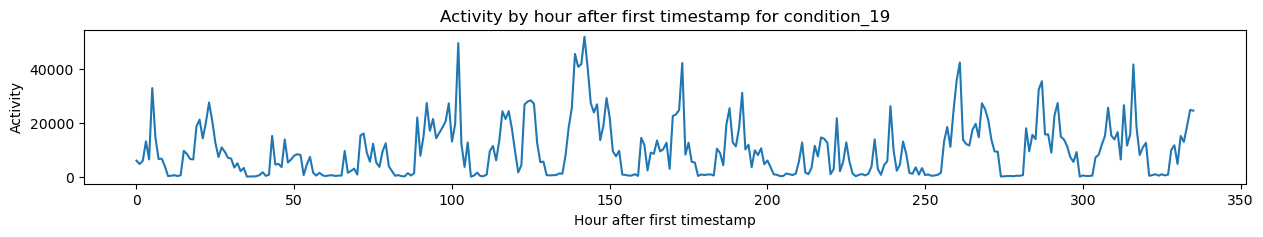

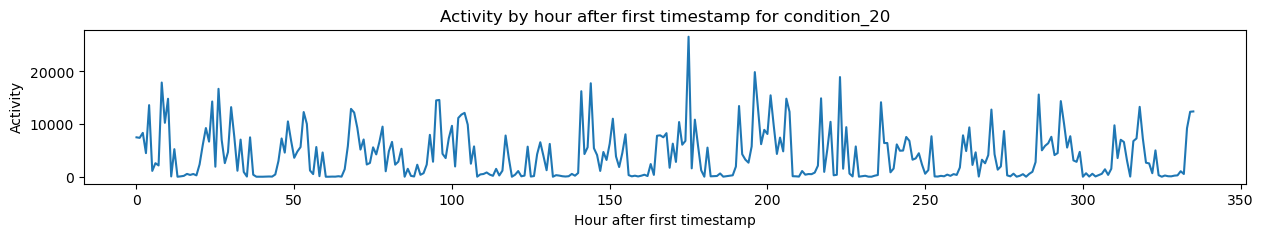

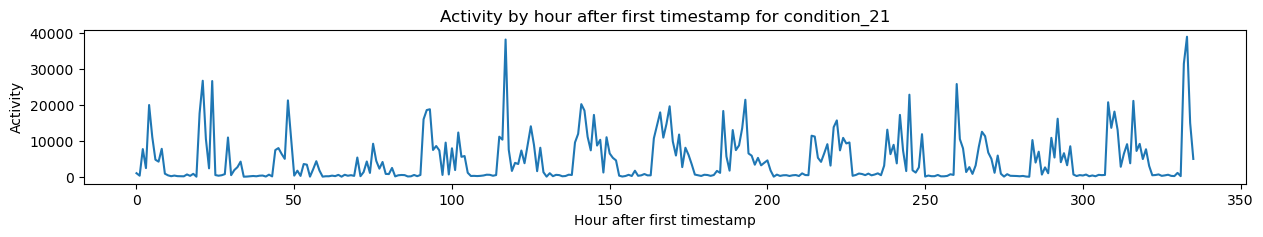

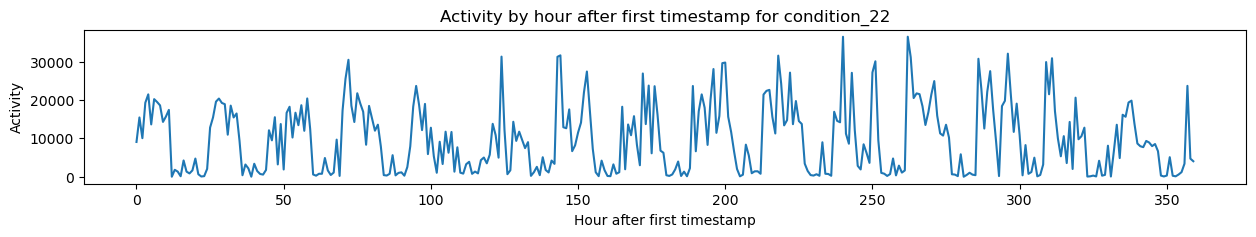

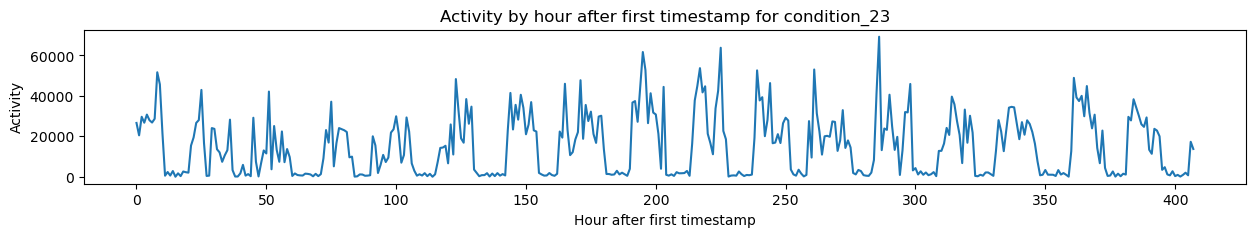

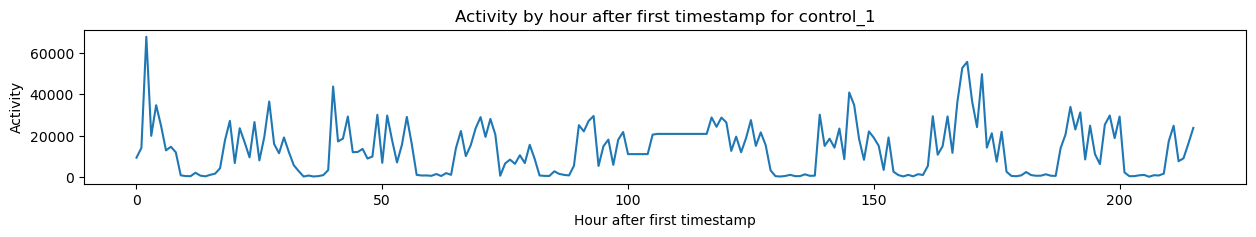

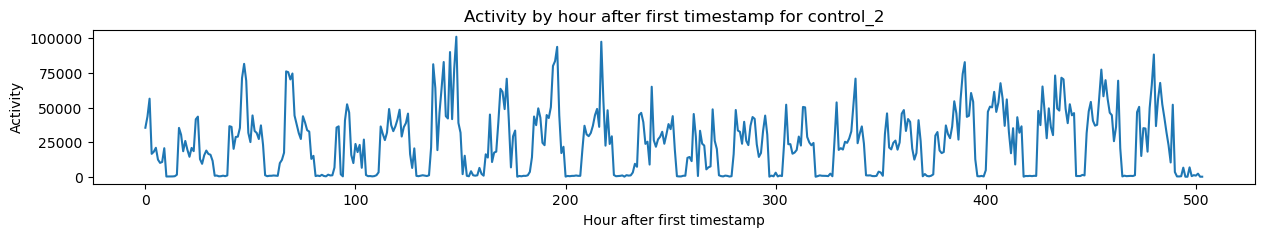

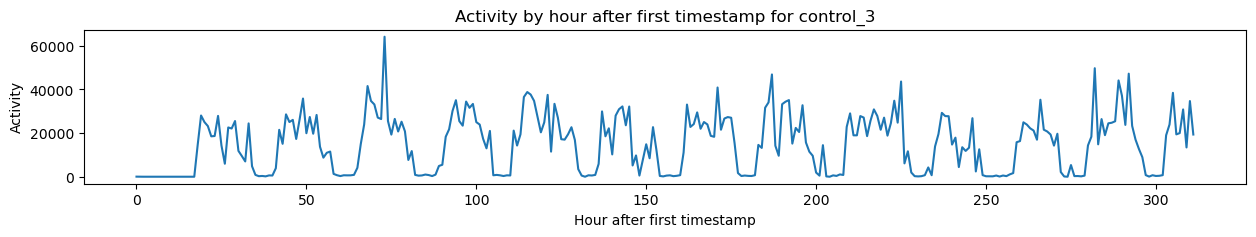

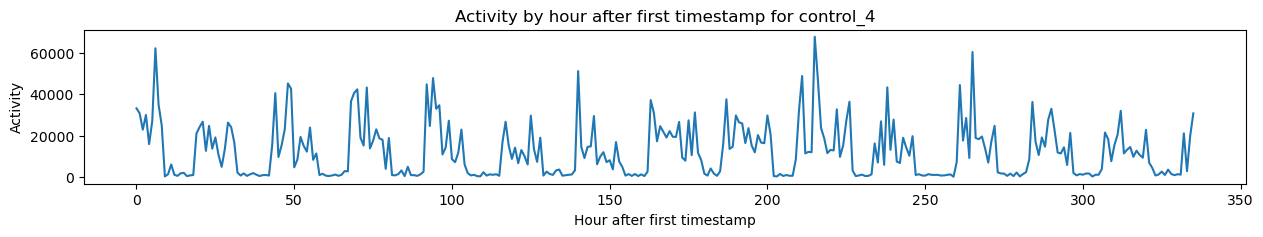

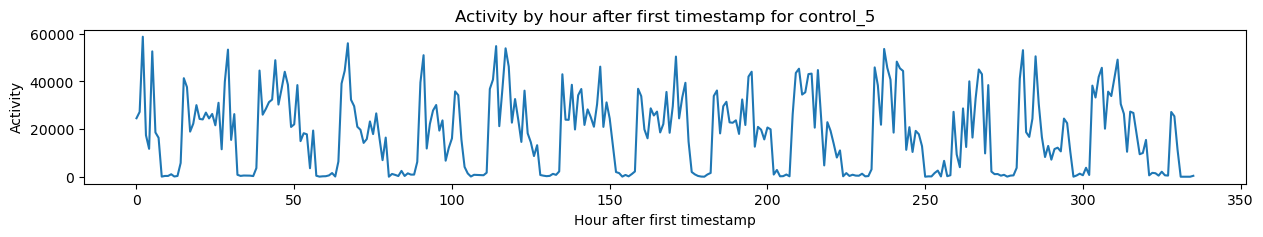

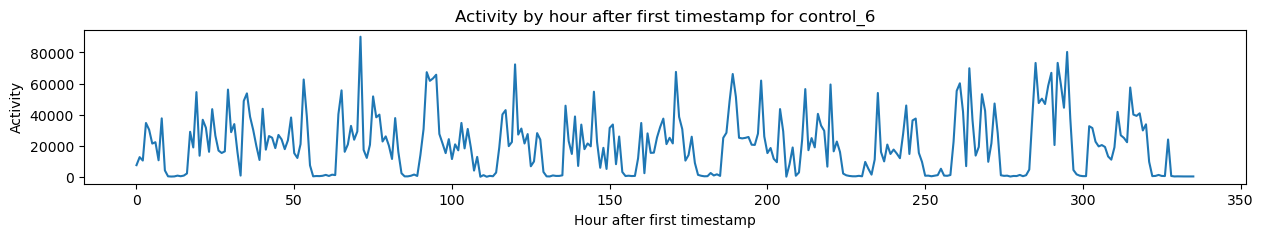

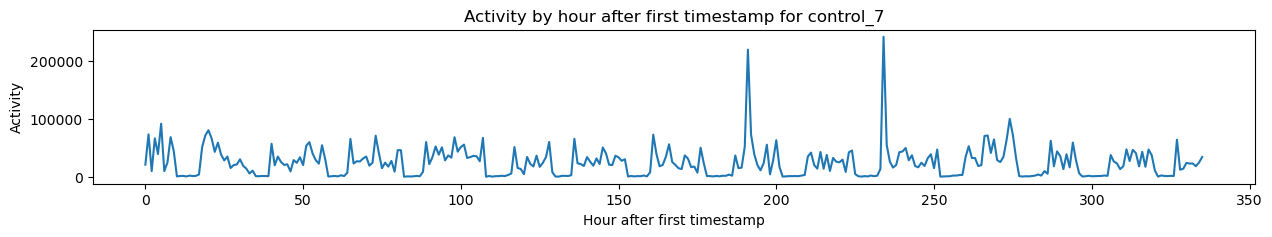

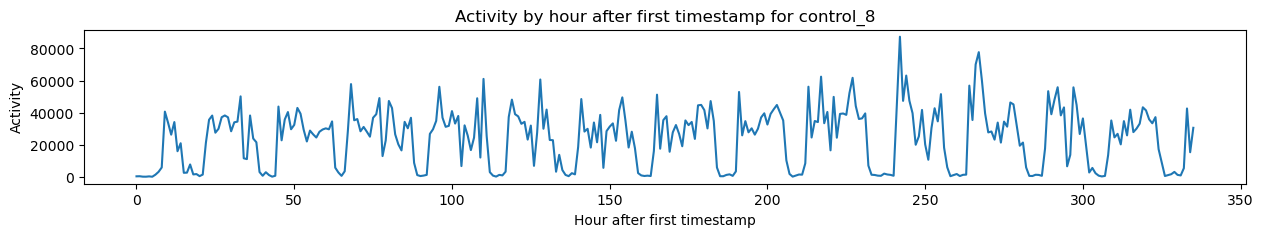

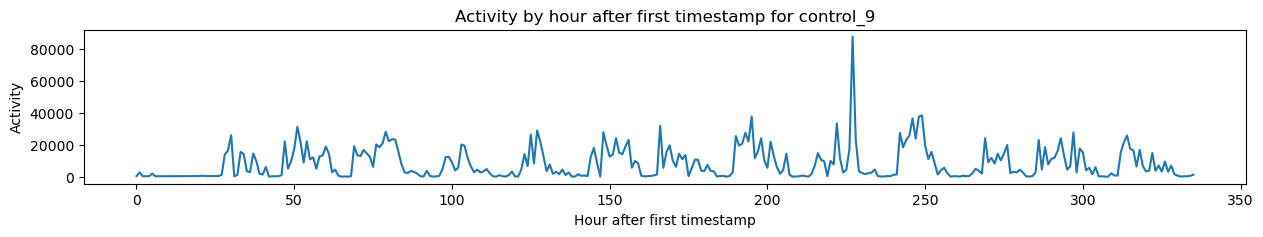

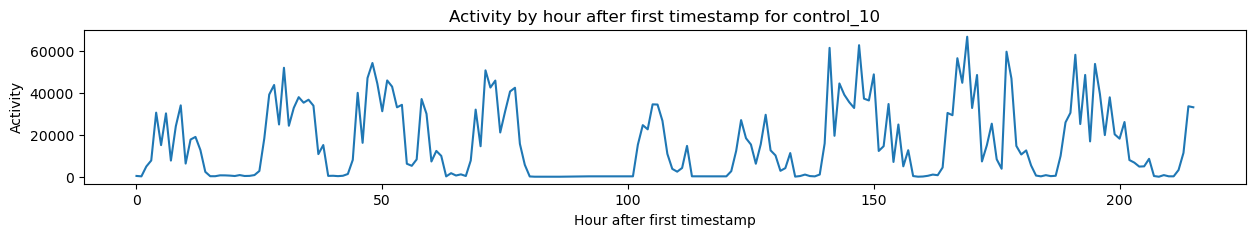

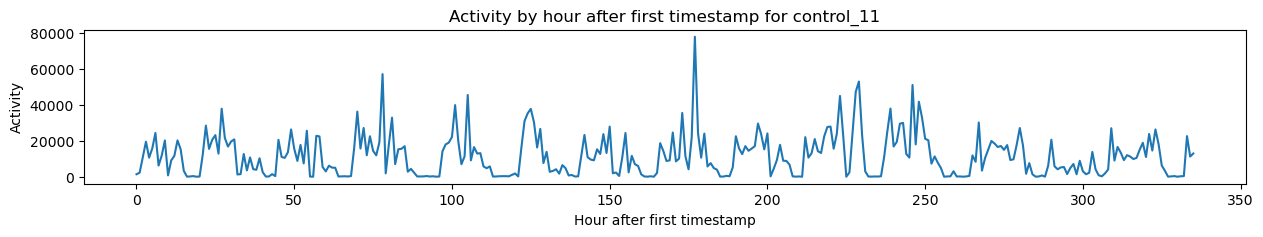

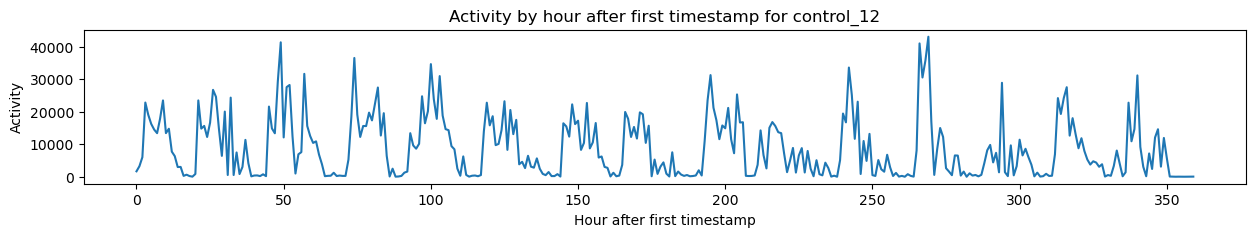

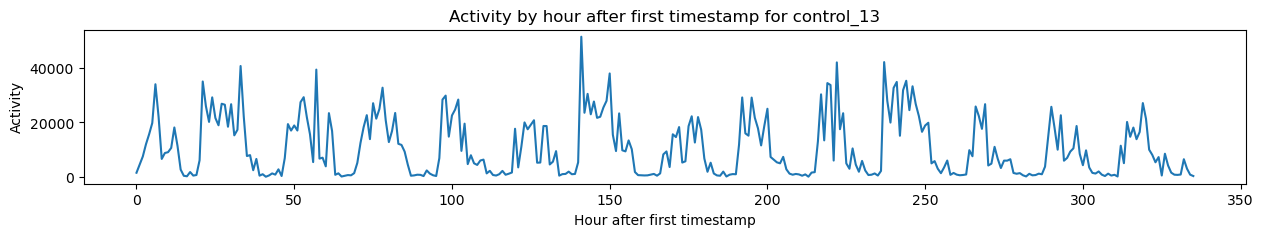

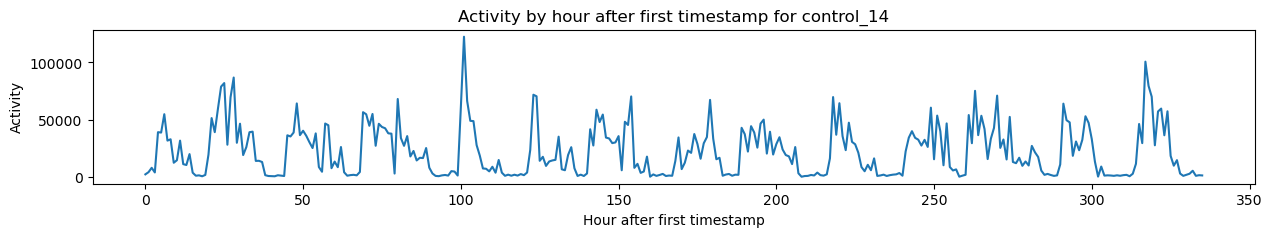

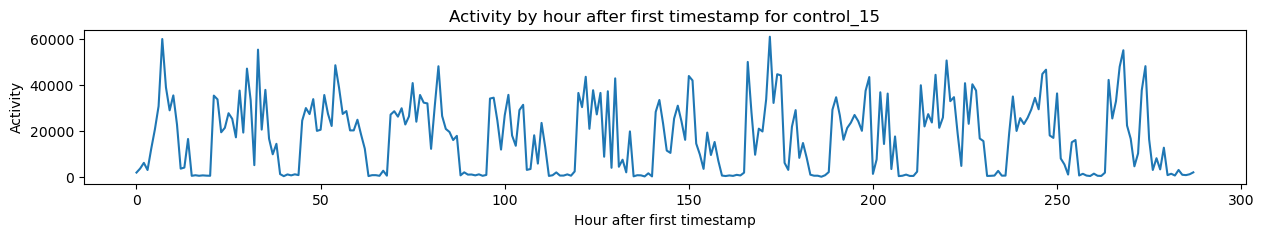

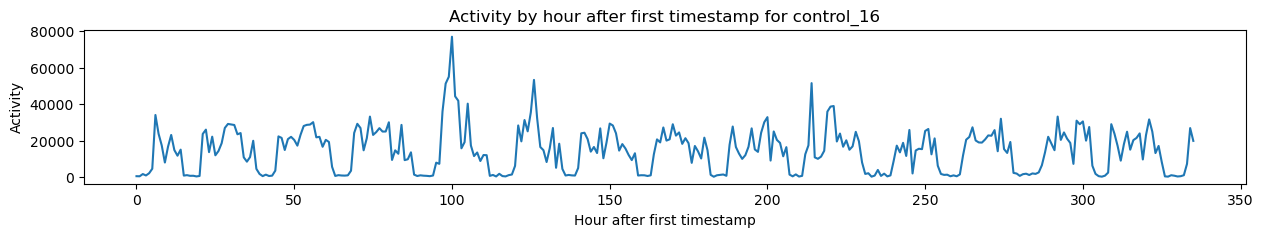

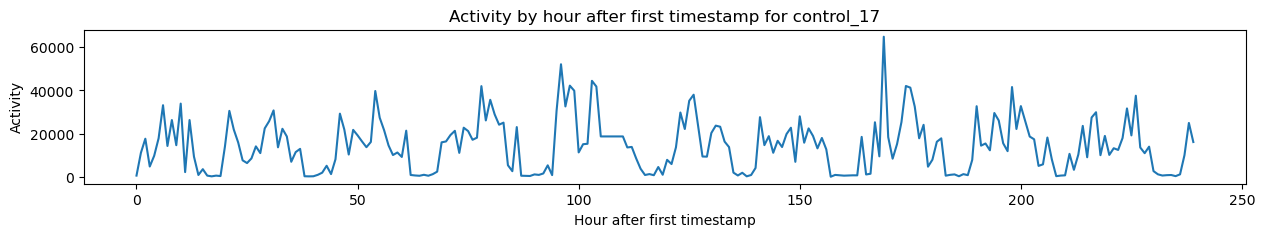

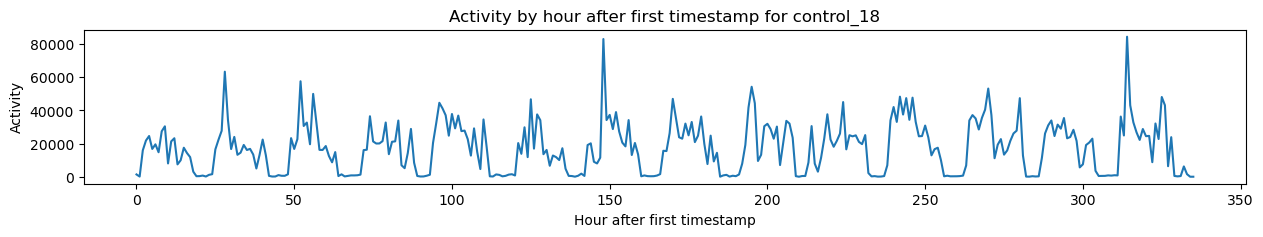

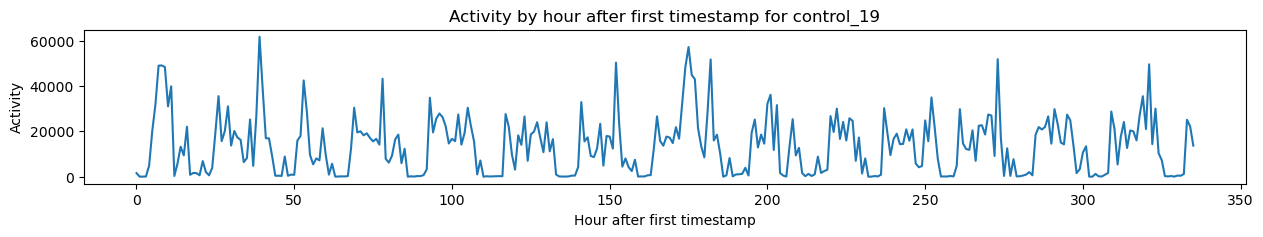

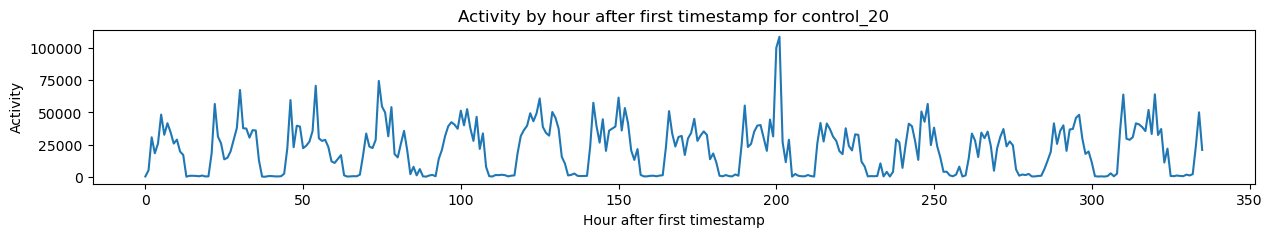

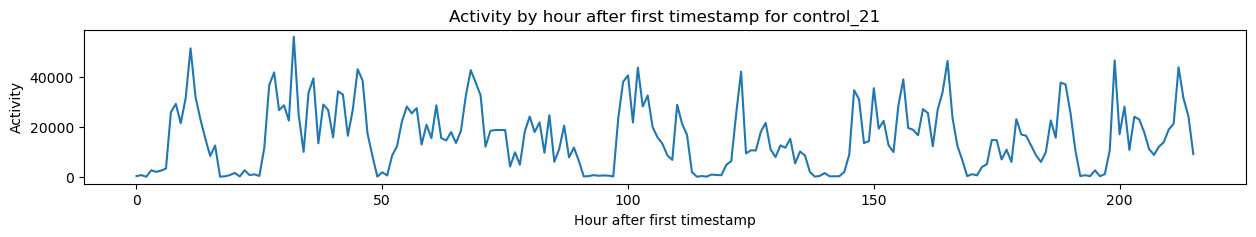

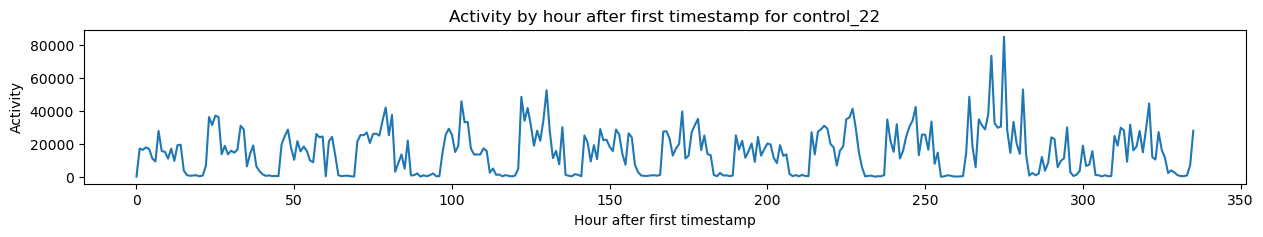

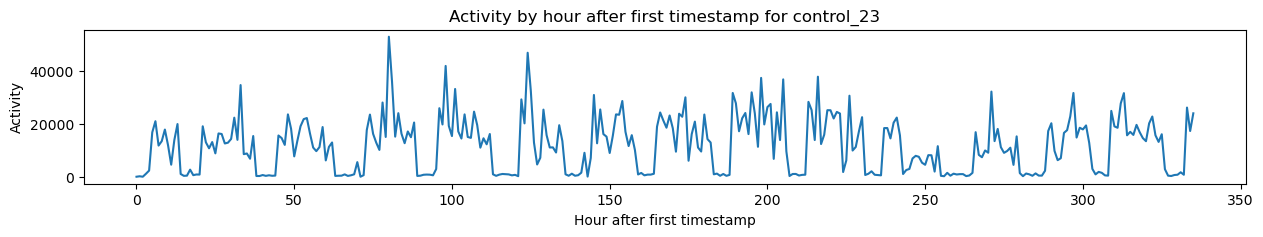

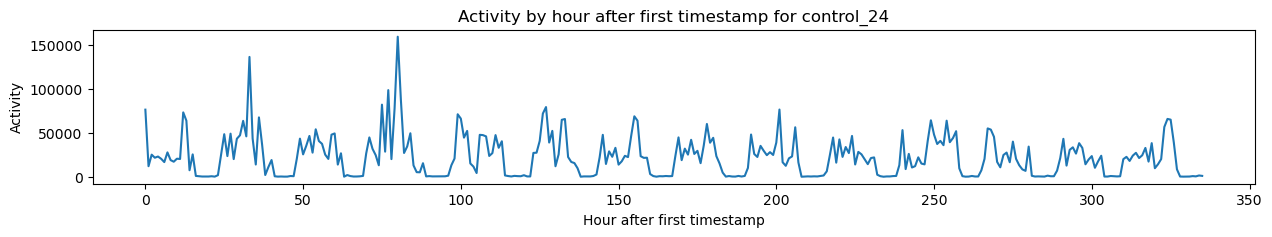

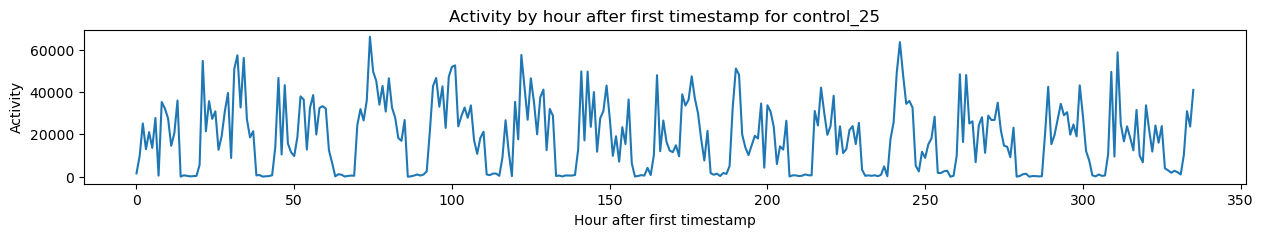

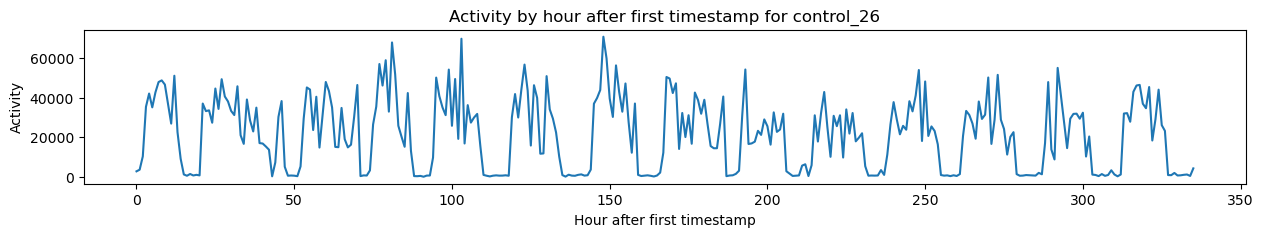

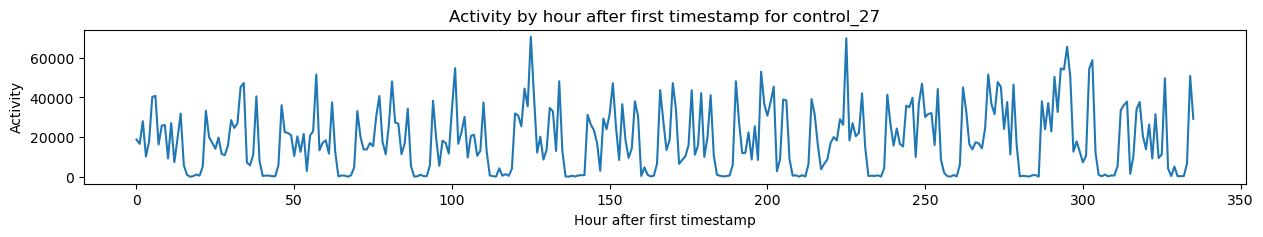

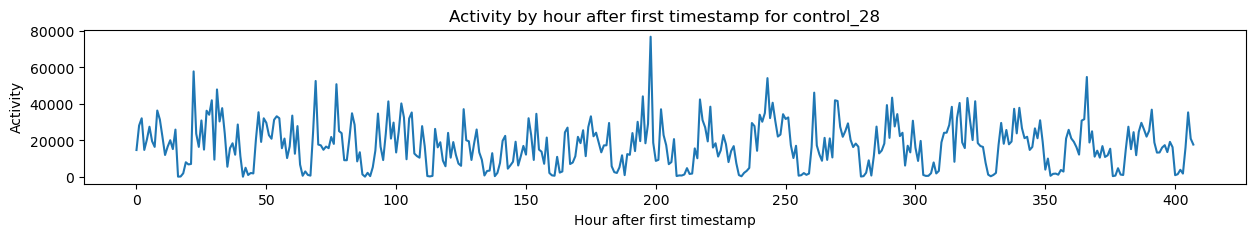

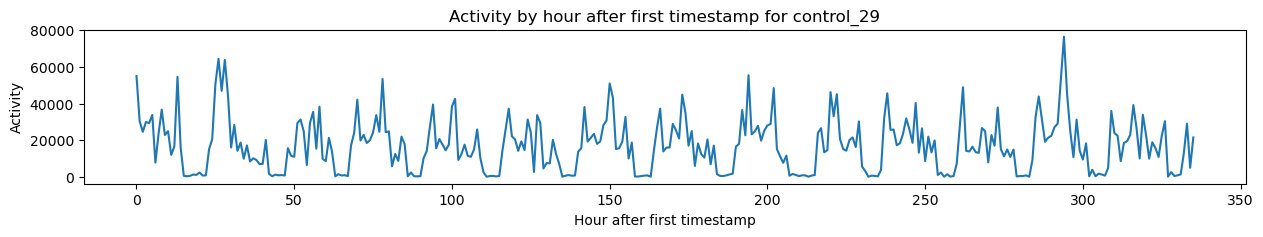

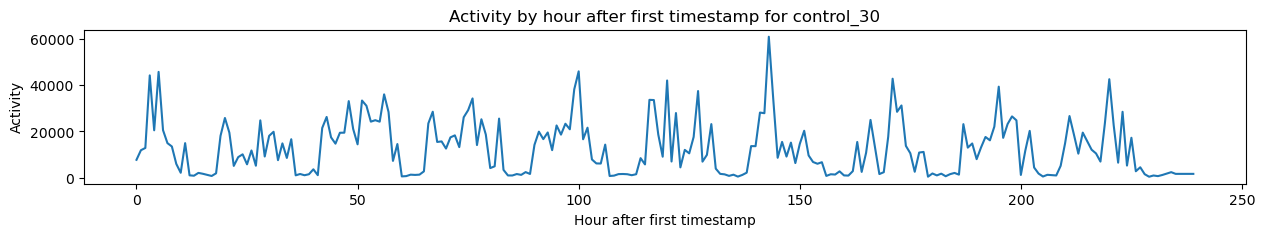

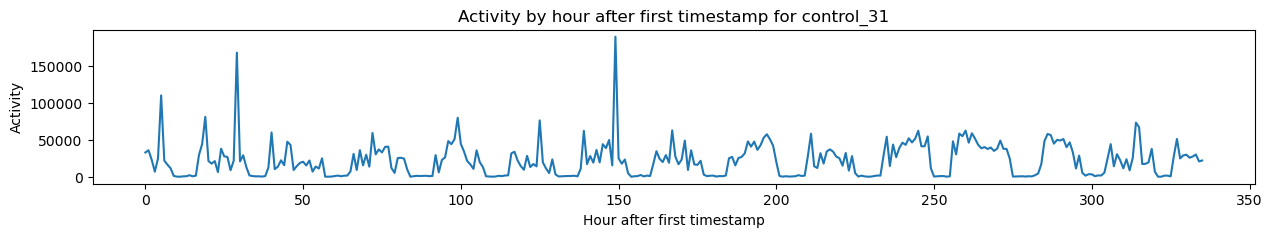

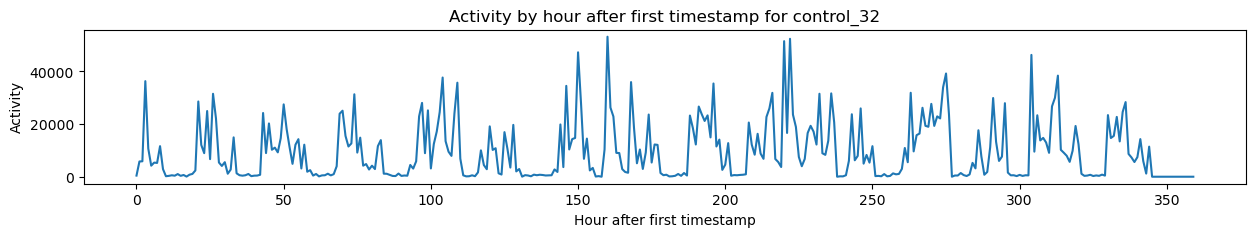

In [16]:
# For every unique number, plot the activity values aggregated by hour after first timestamp to check
for number in df_merged['number'].unique():
    plt.figure(figsize=(15,2))
    df_merged[df_merged['number'] == number].groupby('hour_after_first')['activity'].sum().plot()
    plt.title("Activity by hour after first timestamp for " + number)
    plt.xlabel("Hour after first timestamp")
    plt.ylabel("Activity")
    plt.show()    

### Visualise distribution of activity by time and group

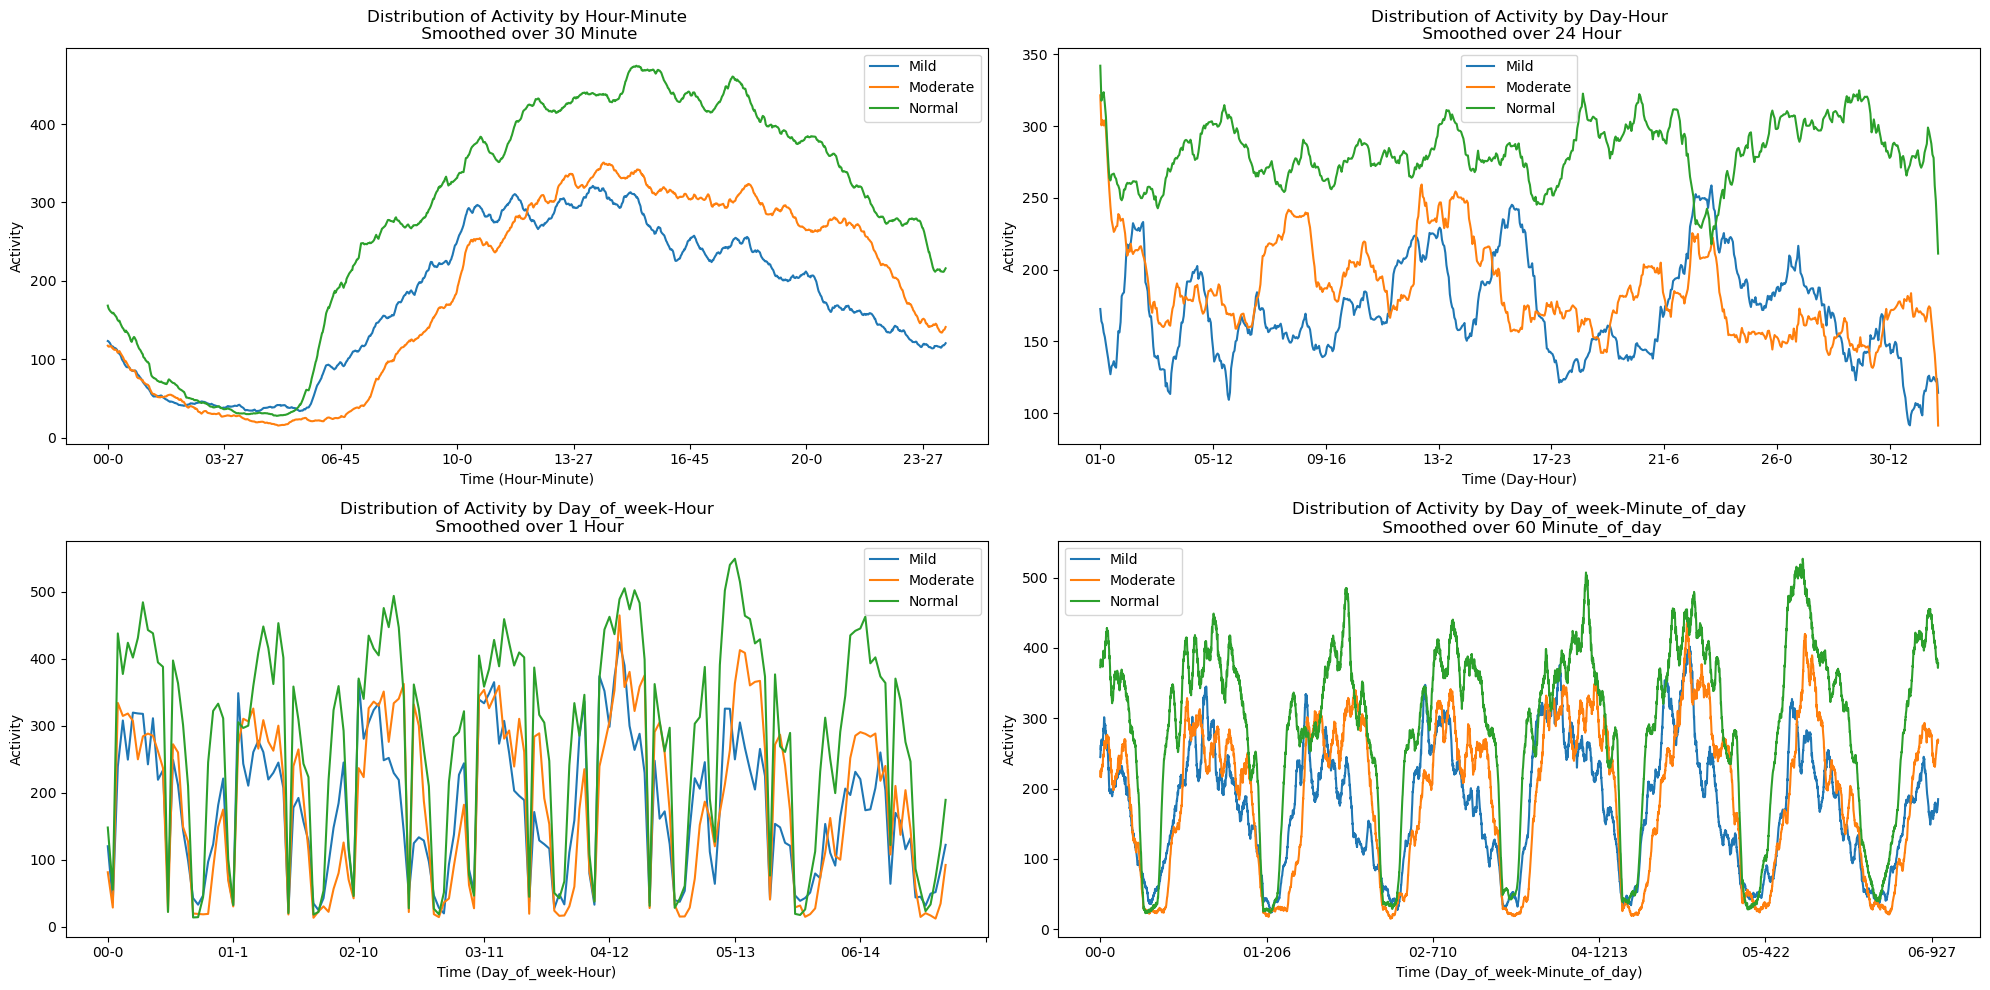

In [17]:
def time_activity_plot_single(data, time_col, window_size=1, ax=None):
    """Plot activity by single time_col (e.g., hour, day, day_of_week, week_of_year, month)"""
    madrs2_groups = data['madrs2_grouped'].unique()
    for group in madrs2_groups:
        activity_mean = data[data['madrs2_grouped'] == group].groupby(time_col)['activity'].mean()
        activity_smoothed = activity_mean.rolling(window_size, min_periods=1, center=True).mean()
        activity_smoothed.plot(label=group, ax=ax)
    ax.legend()
    ax.set_xlabel(time_col)
    ax.set_ylabel('Activity')
    ax.set_title(f'Distribution of Activity by {time_col.capitalize()}')

def time_activity_plot_combo(data, time_col_1, time_col_2, window_size=1, ax=None):
    """Plot activity by combination of two time_cols (e.g., hour-minute, day-hour, day_of_week-hour, day_of_week-minute_of_day)"""
    madrs2_groups = data['madrs2_grouped'].unique()
    data['time'] = data[time_col_1].astype(str).str.zfill(2) + '-' + data[time_col_2].astype(str) 
    for group in madrs2_groups:
        activity_mean = data[data['madrs2_grouped'] == group].groupby('time')['activity'].mean()
        activity_smoothed = activity_mean.rolling(window_size, min_periods=1, center=True).mean()
        activity_smoothed.plot(label=group, ax=ax)
    ax.legend()
    ax.set_xlabel(f'Time ({time_col_1.capitalize()}-{time_col_2.capitalize()})')
    ax.set_ylabel('Activity')
    ax.set_title(f'Distribution of Activity by {time_col_1.capitalize()}-{time_col_2.capitalize()}\n Smoothed over {window_size} {time_col_2.capitalize()}')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axs = axs.ravel()

# time_activity_plot_single(df_merged, 'hour', 1, axs[0])
# time_activity_plot_single(df_merged, 'day', 1, axs[1])
# time_activity_plot_single(df_merged, 'day_of_week', 1, axs[2])
# time_activity_plot_single(df_merged, 'week_of_year', 1, axs[3])
# time_activity_plot_single(df_merged, 'month', 1, axs[4])

time_activity_plot_combo(df_merged, 'hour', 'minute', 30, axs[0]) # Smooth over 30 minutes
time_activity_plot_combo(df_merged, 'day', 'hour', 24, axs[1]) # Smooth over 24 hours
time_activity_plot_combo(df_merged, 'day_of_week', 'hour', 1, axs[2]) # No smoothing
time_activity_plot_combo(df_merged, 'day_of_week', 'minute_of_day', 60, axs[3]) # Smooth over 60 minutes

plt.tight_layout()

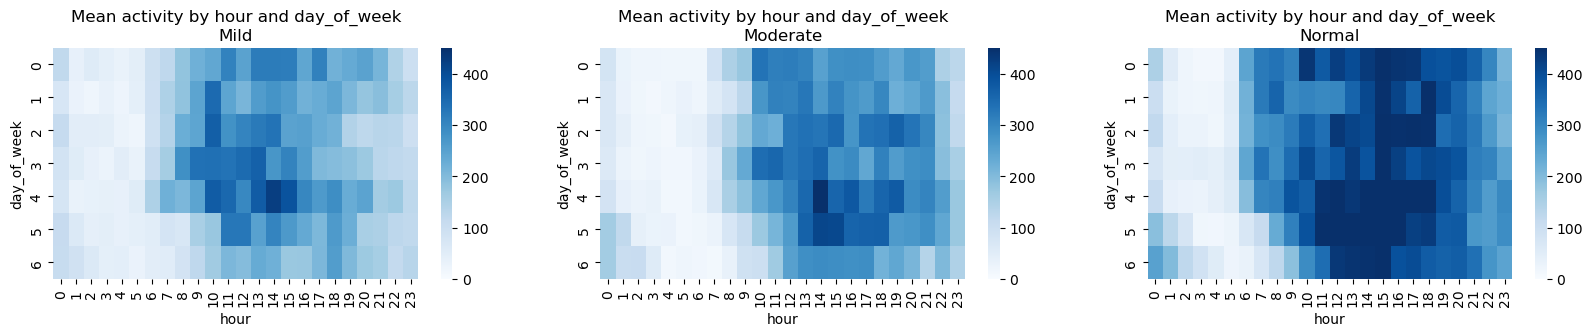

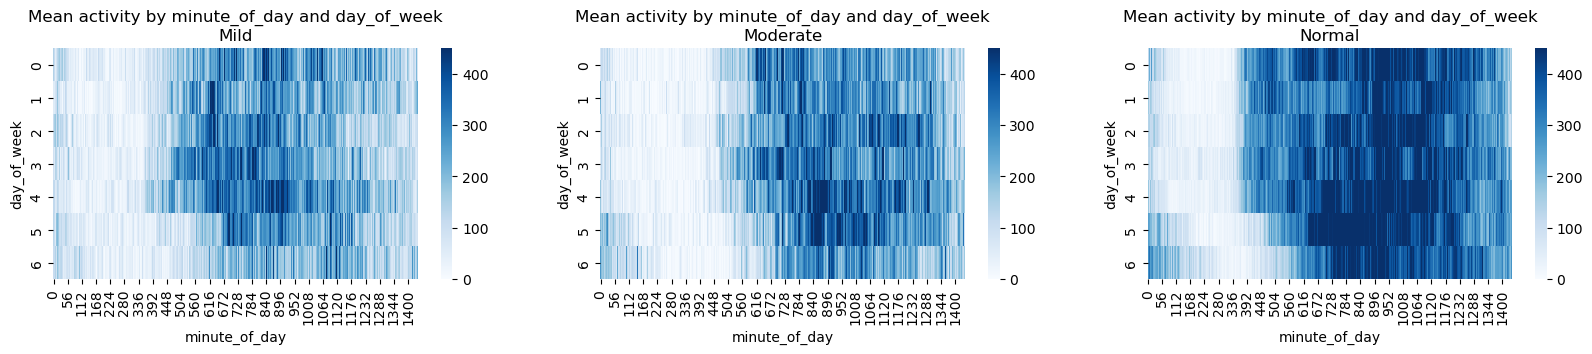

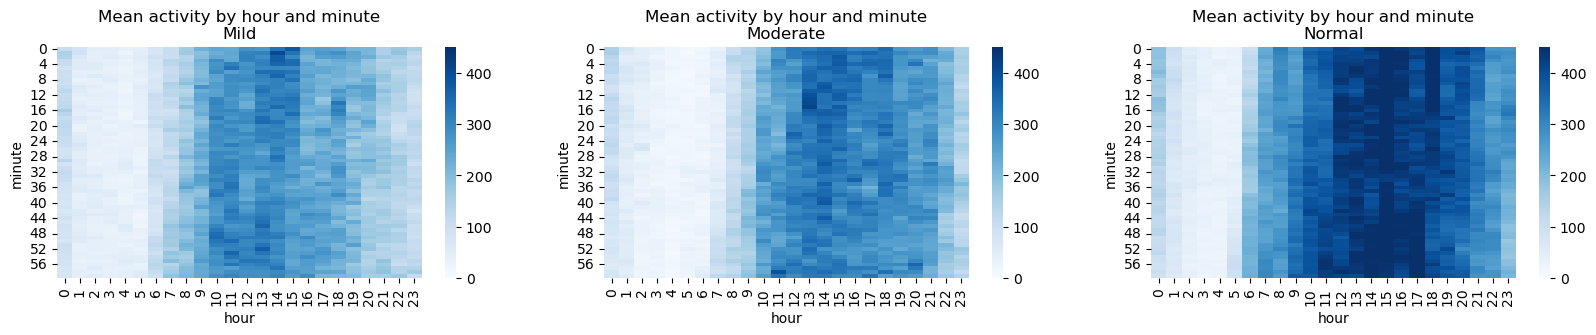

In [18]:
def plot_activity_heatmap(df, x_axis, y_axis):
    """
    This function creates a 1x3 grid of heatmaps of mean activity based on two time scales for each madrs2_group.
    """
    # Create a 1x3 grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 3))

    # Iterate over each madrs2_group
    for i, madrs2_group in enumerate(df['madrs2_grouped'].unique()):
        # Get the subset of the data corresponding to the current madrs2_group
        subset = df[df['madrs2_grouped'] == madrs2_group]

        # Plot a heatmap using of the hour vs. day_of_week with color corresponding to mean activity per cell
        heatmap_data = subset.pivot_table(index=y_axis, columns=x_axis, values='activity', aggfunc='mean')
        sns.heatmap(heatmap_data, cmap='Blues', ax=axes[i], vmin=0, vmax=450)
        axes[i].set_title(f'Mean activity by {x_axis} and {y_axis}\n{madrs2_group}')

plot_activity_heatmap(df_merged, 'hour', 'day_of_week')
plot_activity_heatmap(df_merged, 'minute_of_day', 'day_of_week')
plot_activity_heatmap(df_merged, 'hour', 'minute')

Some notes:
- Week of year or month doesn't seem to be meaningful
- Cyclicality by day of the week and hour - potentially could derive parameters for a sin/cos equation as features?
- Moderate ones seem to start being active in the day later
- Both mild and moderate depression patients have a shorter window of time during the day when they are active
- Bigger variation in activity between days of the week for depressed patients
- Peak activity by hour is equal across the groups
- Given most patient's activity is in the 11-13 day mark, analysis should be on a day_of_week or hourly or minute level
- Patterns differ by day of the week. May need to extract features by minute depending on day of the week

## Feature Extraction

### Add one hot and ordinal encodings for madrs2_grouped to df_merged

In [19]:
# Add one hot encoding for madrs2_grouped while keeping original column
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['madrs2_grouped'])], axis=1)

# Add ordinal encodings where normal = 0, mild = 1, and moderate = 2
madrs2_group_mapping = {'Normal': 0,
                        'Mild': 1,
                        'Moderate': 2}

df_merged['madrs2_grouped_ord'] = df_merged['madrs2_grouped'].map(madrs2_group_mapping)

### Extract features from time series data

We will extract the following features, based on rationale from literature:

1. **Interdaily stability**: Interdaily stability is a measure of the strength of circadian rhythmicity, the degree of consistency of activity patterns from one day to the next. It is calculated as the ratio of the variance of the average 24-hour pattern around the mean to the overall variance. This feature has been found to be useful in discriminating between depressed patients and healthy controls[1][2][3][4]. A study found that depressed patients had lower interdaily stability compared to healthy controls, indicating a less stable activity pattern[1].

2. **Intraday variability**: Intraday variability is a measure of the variability of the activity level within a day. It quantifies the frequency and extent of transitions between periods of rest and activity on an hourly basis. High intraday variability values indicate the occurrence of daytime naps and/or nocturnal activity episodes. This feature has been found to be useful in discriminating between depressed patients and healthy controls[3]. A study found that depressed patients had higher intraday variability compared to healthy controls, indicating a more fragmented activity pattern[3].

4. **Statistical metrics for activity levels**: These features capture different aspects of the activity level of the patients, such as mean activity, standard deviation of activity, skewness of activity, kurtosis of activity, and entropy of activity. They have been found to be useful in discriminating between depressed patients and healthy controls[1][5][3]. For example, a study found that depressed patients had lower mean activity levels and higher variability of activity levels compared to healthy controls, indicating a less active lifestyle[5].

5. **Distribution of activity occurring at different times**: This feature captures the distribution of activity occurring at different times, such as day vs. night and weekday vs. weekend. It has been found to be important for accurately classifying depression status, as there are differences in activity patterns between these periods[1][3][4]. For example, a study found that depressed patients had lower activity levels during the day and higher activity levels during the night compared to healthy controls, indicating a disrupted circadian rhythm[4].

3. **Statistical metrics for activity bouts and inactivity bouts**: These features capture different aspects of the activity patterns of the patients, such as the number of bouts, mean bout duration, standard deviation of bout duration, skewness of bout duration, kurtosis of bout duration, and entropy of bout duration. They have been found to be useful in discriminating between depressed patients and healthy controls[1][5][3]. For example, a study found that depressed patients had fewer and longer bouts of activity compared to healthy controls, indicating a less active lifestyle[5].

Overall, these features capture different aspects of the activity patterns and levels of the patients, and have been found to be useful in discriminating between depressed patients and healthy controls using machine learning algorithms. Interdaily stability and intraday variability are particularly relevant for discriminating between mildly depressed and moderately depressed patients, as they capture the stability and variability of the activity pattern over multiple days and within a day, respectively.

Note that statistical metrics will include:
1. Number of bouts: Captures the number of distinct periods of activity and inactivity throughout the day
1. Mean (of bout duration / activity levels)
1. Standard deviation (of bout duration / activity levels)
1. Coefficient of variation (of bout duration / activity levels): Standard deviation / mean - corrects for differences in mean by patient
1. Skewness (of bout duration / activity levels): Measures asymmetry of the distribution
1. Kurtosis (of bout duration / activity levels): Measures peakedness of distribution
1. Entropy (of bout duration / activity levels): Measures complexity of the distribution

Citations:
[1] https://www.radc.rush.edu/docs/var/detail.htm?category=Sleep+and+Circadian+Rhythms&subcategory=Sensor+device+measures&variable=is
[2] https://sleepscience.org.br/details/527/en-US/a-nonparametric-methodological-analysis-of-rest-activity-rhythm-in-type-2-diabetes
[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4559593/
[4] https://pure.uva.nl/ws/files/1216705/2123_22039y.pdf
[5] https://www.researchgate.net/publication/271767741_Nonparametric_methods_in_actigraphy_An_update

By Perplexity at https://www.perplexity.ai/search/0055e9bc-5385-458c-bfed-953b4d6909cb

#### Activity-level features

In [20]:
def interday_stability(data):
    """
    Calculates interday stability, which quantifies the variability of patterns within a 24-hour cycle across multiple days
    Interday Stability = Variance of the average 24 hour pattern / Total Variance of the Group
    """
    # Calculate average 24-hour pattern for the group
    mean_24h_pattern = data['activity'].groupby([data.timestamp.dt.hour]).mean()

    # Calculate variance of the average 24-hour pattern
    var_24h_pattern = np.var(mean_24h_pattern)

    # Calculate total variance of the group
    total_var = np.var(data['activity'])

    # Calculate Interdaily Stability for the group
    interday_stability = var_24h_pattern / total_var

    return interday_stability

def intraday_variability(data):
    """
    Calculates intraday variability, which represents the level of variability within a single day relative to average activity level for that day
    Intraday Variability = Variance of activity values within a single day / Mean activity value for that day
    """
    # Group the data by date and calculate the variance within each day
    daily_variances = data.groupby(data.timestamp.dt.date)['activity'].var()

    # Calculate the mean activity value for each day
    daily_means = data.groupby(data.timestamp.dt.date)['activity'].mean()

    # Calculate the intraday variability by dividing the daily variances by the daily means
    intraday_variability = np.mean(daily_variances / daily_means)

    return intraday_variability

def pct_day_activity(data, hour_start, hour_end):
    """
    Calculate the percentage of activity occurring in a time window (e.g., 08:00-12:00)
    """
    # Calculate sum of activity
    total_activity = data['activity'].sum()
    
    if hour_start < hour_end:
        window_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].sum()
    else: 
        window_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].sum()

    # Calculate percentage of activity during each window
    pct_activity = window_activity / total_activity if total_activity > 0 else 0

    return pct_activity

def pct_weekday_activity(data):
    """
    Calculate the percentage of activity occurring in weekdays
    """
    # Calculate sum of activity
    total_activity = data['activity'].sum()

    window_activity = data[data['timestamp'].dt.dayofweek.between(0,4)]['activity'].sum()

    # Calculate percentage of activity during selected days
    pct_activity = window_activity / total_activity if total_activity > 0 else 0

    return pct_activity

def mean_activity_window(data, hour_start, hour_end, weekdays=True):
    """
    Calculate mean activity during a time window (e.g., 08:00-12:00) for specific days of the week
    (e.g., weekdays, weekends, Mondays, Tuesdays, etc.)
    """
    if weekdays:
        # filter data to only include weekdays
        data = data[data['timestamp'].dt.dayofweek.between(0, 4)]
        if hour_start < hour_end:
            mean_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].mean()
        else:
            mean_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].mean()
    else:
        # filter data to only include weekends
        data = data[data['timestamp'].dt.dayofweek.between(5, 6)]
        if hour_start < hour_end:
            mean_activity = data[data['timestamp'].dt.hour.between(hour_start, hour_end)]['activity'].mean()
        else:
            mean_activity = data[(data['timestamp'].dt.hour >= hour_start) | (data['timestamp'].dt.hour < hour_end)]['activity'].mean()

    return mean_activity

In [21]:
def calculate_activity_features(data):
    """
    Group data by number and calculate activity-based features for each number
    """

    # Create an empty DataFrame to store the features
    df = pd.DataFrame()

    # Get madrs2_grouped values for each number
    df['madrs2_grouped'] = data.groupby('number')['madrs2_grouped'].first()
    df['madrs2_grouped_ord'] = data.groupby('number')['madrs2_grouped_ord'].first()
    df['Normal'] = data.groupby('number')['Normal'].first()
    df['Mild'] = data.groupby('number')['Mild'].first()
    df['Moderate'] = data.groupby('number')['Moderate'].first()
       
    # Interday stability
    df['activity_interday_stability'] = data.groupby('number').apply(interday_stability)
    
    # Intradaily variability
    df['activity_intraday_variability'] = data.groupby('number').apply(intraday_variability)

    # Mean activity
    df['activity_mean'] = data.groupby('number')['activity'].mean()

    # Mean activity for different times of the week
    # Create a for loop to calculate mean activity for different times of the week
    for weekdays in [True, False]:
        for hour_start, hour_end in [(0, 6), (6, 12), (12, 18), (18, 0)]:
            if weekdays:
                df[f'activity_mean_weekdays_{hour_start}to{hour_end}'] = data.groupby('number').apply(lambda x: mean_activity_window(x, hour_start=hour_start, hour_end=hour_end, weekdays=weekdays))
            else:
                df[f'activity_mean_weekends_{hour_start}to{hour_end}'] = data.groupby('number').apply(lambda x: mean_activity_window(x, hour_start=hour_start, hour_end=hour_end, weekdays=weekdays))

    # Standard deviations of activity level
    df['activity_std_minutely'] = data.groupby('number')['activity'].std()
    df['activity_std_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].var().groupby('number').std()
    df['activity_std_daily'] = data.groupby(['number', 'day_after_first'])['activity'].var().groupby('number').std()

    # Coefficient of variation of activity level
    df['activity_cv_minutely'] = df['activity_std_minutely'] / df['activity_mean']
    df['activity_cv_hourly'] = df['activity_std_hourly'] / df['activity_mean']
    df['activity_cv_daily'] = df['activity_std_daily'] / df['activity_mean']

    # Kurtosis of activity level
    df['activity_kurtosis_minutely'] = data.groupby('number')['activity'].apply(stats.kurtosis)
    df['activity_kurtosis_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.kurtosis).groupby('number').mean()
    df['activity_kurtosis_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.kurtosis).groupby('number').mean()

    # Skewness of activity level
    df['activity_skewness_minutely'] = data.groupby('number')['activity'].apply(stats.skew)
    df['activity_skewness_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.skew).groupby('number').mean()
    df['activity_skewness_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.skew).groupby('number').mean()

    # Entropy of activity level
    df['activity_entropy_minutely'] = data.groupby('number')['activity'].apply(stats.entropy)
    df['activity_entropy_hourly'] = data.groupby(['number', 'hour_after_first'])['activity'].apply(stats.entropy).groupby('number').mean()
    df['activity_entropy_daily'] = data.groupby(['number', 'day_after_first'])['activity'].apply(stats.entropy).groupby('number').mean()

    # Percentage of activity occuring on weekdays
    df['activity_pct_weekday'] = data.groupby('number').apply(pct_weekday_activity)
    
    # Percentage of activity occurring during 12-hour time windows - note to figure out the best splits to maximise the difference between groups
    df['activity_pct_0to6'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 0, 6))
    df['activity_pct_6to12'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 6, 12))
    df['activity_pct_12to18'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 12, 18))
    df['activity_pct_18to0'] = data.groupby('number').apply(lambda x: pct_day_activity(x, 18, 24))

    return df

# Group the DataFrame by 'number' and apply the function to each group
df_activity_features = calculate_activity_features(df_merged)

df_activity_features.head()

/Users/nhanle/miniforge3/envs/w207_final/lib/python3.9/site-packages/pandas/core/groupby/ops.py:839: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = f(group)
/Users/nhanle/miniforge3/envs/w207_final/lib/python3.9/site-packages/pandas/core/groupby/ops.py:839: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = f(group)
/Users/nhanle/miniforge3/envs/w207_final/lib/python3.9/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


madrs2_grouped  madrs2_grouped_ord  Normal  Mild  Moderate  \
number                                                                    
condition_1            Mild                   1       0     1         0   
condition_10       Moderate                   2       0     0         1   
condition_11       Moderate                   2       0     0         1   
condition_12       Moderate                   2       0     0         1   
condition_13           Mild                   1       0     1         0   

              activity_interday_stability  activity_intraday_variability  \
number                                                                     
condition_1                      0.208737                     429.453604   
condition_10                     0.272192                     580.711403   
condition_11                     0.100964                     542.382958   
condition_12                     0.182716                     433.170487   
condition_13                     0.150851                     487.534039   

              activity_mean  activity_mean_weekdays_0to6  \
number                                                     
condition_1      155.345969                    13.887798   
condition_10     321.150497                    20.453869   
condition_11     132.735775                    23.998701   
condition_12     174.285592                    24.438095   
condition_13     262.156813                    86.758009   

              activity_mean_weekdays_6to12  ...  activity_skewness_hourly  \
number                                      ...                             
condition_1                     176.043168  ...                  2.900141   
condition_10                    359.293540  ...                  2.285856   
condition_11                     85.350509  ...                  3.279815   
condition_12                    162.710505  ...                  2.448947   
condition_13                    345.706863  ...                  2.224653   

              activity_skewness_daily  activity_entropy_minutely  \
number                                                             
condition_1                  2.659355                   8.663761   
condition_10                 1.831196                   8.761910   
condition_11                 3.331417                   8.574181   
condition_12                 2.641763                   8.830955   
condition_13                 2.041379                   9.148900   

              activity_entropy_hourly  activity_entropy_daily  \
number                                                          
condition_1                  2.724946                6.212151   
condition_10                 3.082170                6.455354   
condition_11                 2.381846                5.798368   
condition_12                 2.956989                6.268560   
condition_13                 3.066736                6.437042   

              activity_pct_weekday  activity_pct_0to6  activity_pct_6to12  \
number                                                                      
condition_1               0.726460           0.029865            0.315593   
condition_10              0.800193           0.017936            0.318777   
condition_11              0.723799           0.122372            0.147103   
condition_12              0.720549           0.058488            0.222638   
condition_13              0.793534           0.097373            0.332778   

              activity_pct_12to18  activity_pct_18to0  
number                                                 
condition_1              0.563898            0.267338  
condition_10             0.504363            0.315222  
condition_11             0.512001            0.355913  
condition_12             0.523571            0.336767  
condition_13             0.424468            0.280819  

[5 rows x 36 columns]

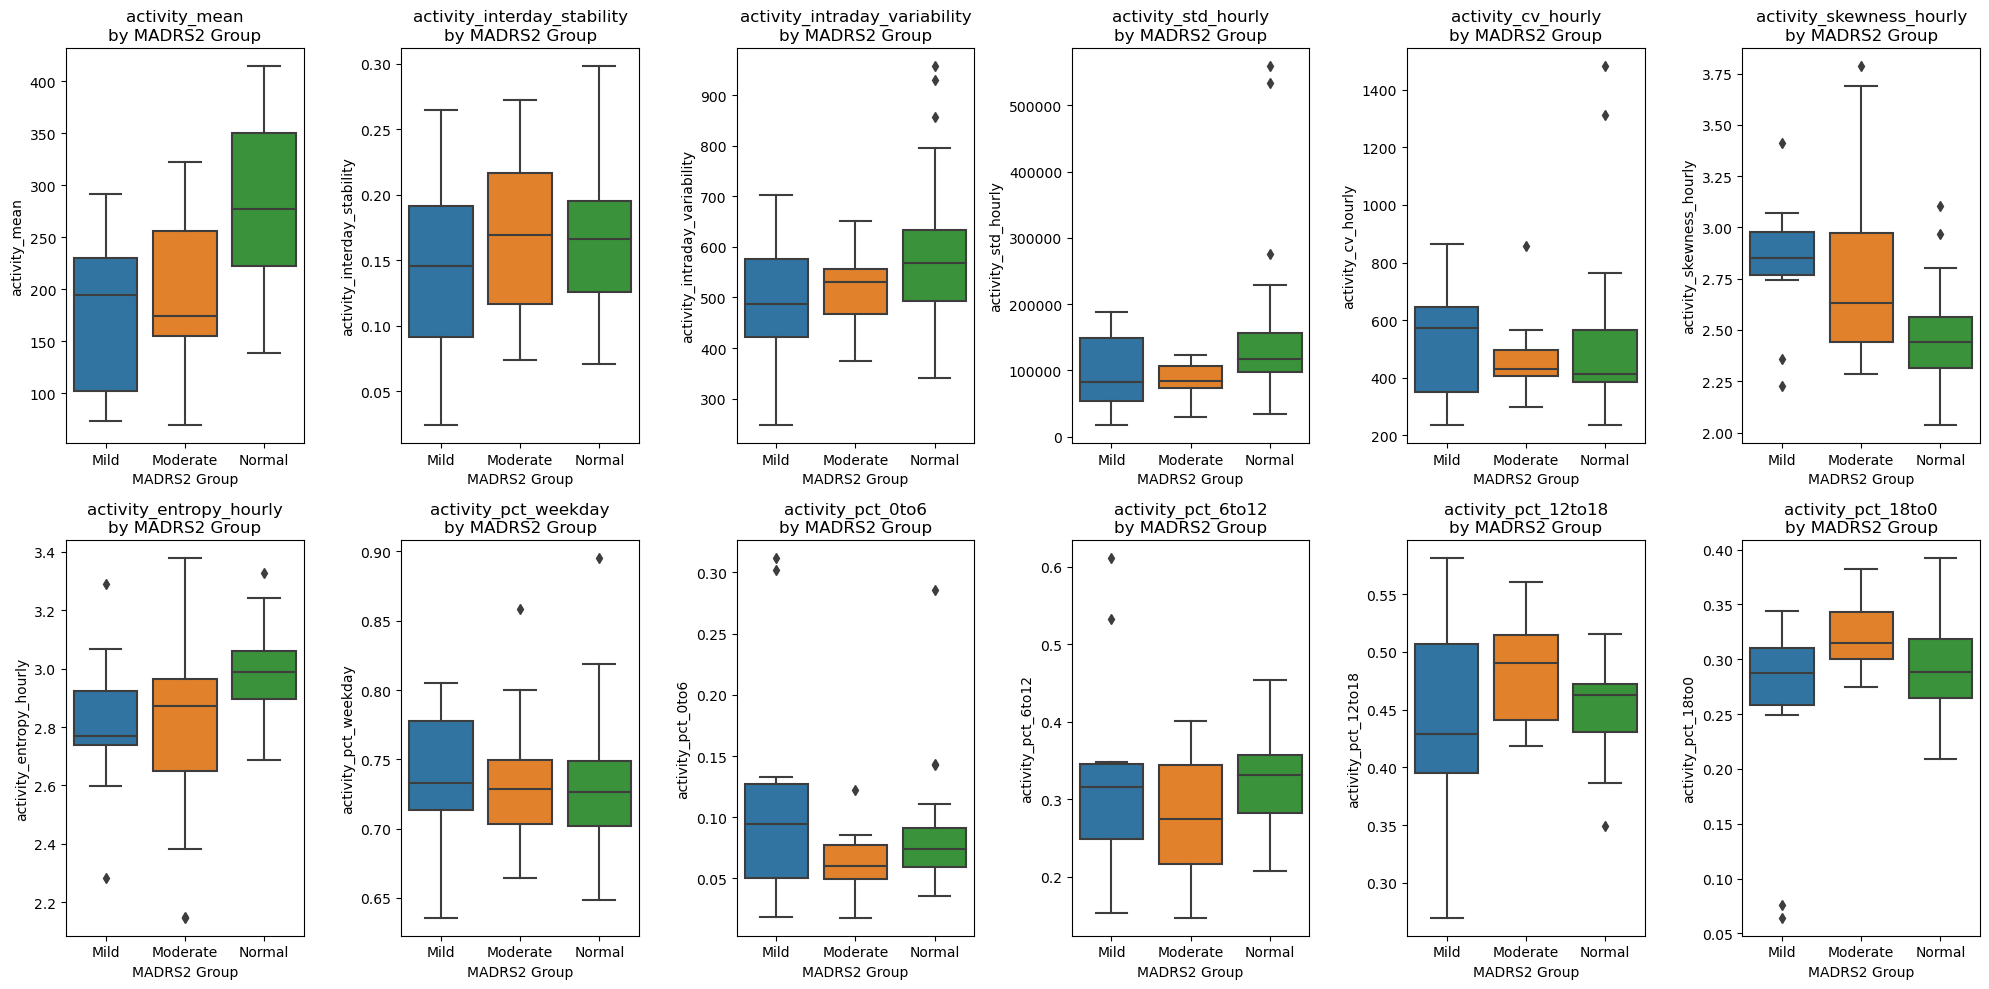

In [22]:
def plot_features(data, rows, cols, features, figsize=(20, 10)):
    """Plot features by MADRS2 Group"""
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()
    for i, col in enumerate(features):
        sns.boxplot(data=data, x='madrs2_grouped', y=col, ax=axs[i])
        axs[i].set_title(f'{col}\nby MADRS2 Group')
        axs[i].set_xlabel('MADRS2 Group')
        axs[i].set_ylabel(col)
    plt.tight_layout()

plot_features(df_activity_features, rows=2, cols=6, features=['activity_mean',
                                                            'activity_interday_stability',
                                                            'activity_intraday_variability',
                                                            'activity_std_hourly',                                           
                                                            'activity_cv_hourly',
                                                            'activity_skewness_hourly',
                                                            'activity_entropy_hourly',
                                                            'activity_pct_weekday',
                                                            'activity_pct_0to6',
                                                            'activity_pct_6to12',
                                                            'activity_pct_12to18',
                                                            'activity_pct_18to0'])

Key findings:
1. Mean activity distinguishes between groups
1. Both interday stability and intraday stability appear to be predictive
1. More meaningful differences for coefficient of variation (cv) than for standard deviation - helps to distinguish between mild and moderate
1. Kurtosis and skewness seem somewhat similar. Distribution of skewness in 'moderate' is such that kurtosis maybe a better metric
1. Distribution of activity in terms of weekend vs. weekday split does not appear to distinguish between groups
1. Distribution of activity in terms of hours distinguishes between groups: Each class appears to have distinct distribution of activity

#### Activity/Inactivity Bout Features

To calculate features based on activity/inactivity bouts, we need to first create new dataframes where each row corresponds to a bout of activity or inactivity before applying aggregating functions to these dataframes.

Based on the search results, here are some good minimum bout duration thresholds and activity thresholds using Actiwatch data:

- Minimum bout duration threshold: 3 minutes[1]
- Activity thresholds:
  - Moderate-to-vigorous physical activity (MVPA) threshold: ≥500 counts per minute (cpm), ≥1000 cpm, ≥2000 cpm, and ≥3000 cpm[1][2][3]
  - Minimum threshold for activity duration: 10 minutes[4]

Citations:
[1] https://www.nature.com/articles/s41366-018-0152-8
[2] https://ijbnpa.biomedcentral.com/articles/10.1186/1479-5868-11-34
[3] https://www.sciencedirect.com/science/article/pii/S2211335516301231
[4] https://www.physio-pedia.com/images/c/c7/Quidelines_for_interpreting_the_IPAQ.pdf
[5] https://health.gov/sites/default/files/2019-09/07_F-1_Physical-Activity_Behaviors_Steps_Bouts_and_High_Intensity_Training.pdf

By Perplexity at https://www.perplexity.ai/search/26b5831c-6c47-4589-ba73-5d0c06cbd0ed

In [30]:
def make_bout_dfs(data, activity_threshold=200, duration_threshold=3):
    """
    Returns two dataframes, one for activity bouts and one for inactivity bouts.
    Each contains bouts numbered by bout number, with duration of each bout.
    """
    
    # Keep only relevant columns
    df_activity = data[['number', 'madrs2_grouped', 'madrs2_grouped_ord', 'timestamp', 'activity']].copy()

    # Calculate rolling mean of activity levels over a window of 3 minutes
    df_activity['activity_mean'] = df_activity['activity'].rolling(window=3).mean()

    # Identify whether the activity level is above the activity threshold
    df_activity['activity_bout'] = df_activity['activity_mean'] >= activity_threshold

    # Number the bouts
    df_activity['bout_num'] = (df_activity['activity_bout'] != df_activity['activity_bout'].shift(1)).cumsum()

    # Add a new column, activity_bout_num and inactivity_bout_num that takes the value for bout_num if activity_bout is True or False, respectively
    df_activity['activity_bout_num'] = df_activity['bout_num'].where(df_activity['activity_bout'])
    df_activity['inactivity_bout_num'] = df_activity['bout_num'].where(~df_activity['activity_bout'])

    # Calculate duration of each bout
    df_activity['activity_bout_duration'] = df_activity.groupby('activity_bout_num')['timestamp'].transform(lambda x: (x.max() - x.min()).seconds / 60)
    df_activity['inactivity_bout_duration'] = df_activity.groupby('inactivity_bout_num')['timestamp'].transform(lambda x: (x.max() - x.min()).seconds / 60)

    # Set duration to NaN if activity_bout_duration is less than duration_threshold
    df_activity.loc[df_activity['activity_bout_duration'] < duration_threshold, 'activity_bout_duration'] = np.nan
    df_activity.loc[df_activity['inactivity_bout_duration'] < duration_threshold, 'inactivity_bout_duration'] = np.nan

    # Set activity_bout_num to NaN if activity_bout_duration is less than duration_threshold
    df_activity.loc[df_activity['activity_bout_duration'].isna(), 'activity_bout_num'] = np.nan
    df_activity.loc[df_activity['inactivity_bout_duration'].isna(), 'inactivity_bout_num'] = np.nan

    # Apply rank to activity_bout_num and inactivity_bout_num to make this 1, 2, 3, etc.,
    df_activity['activity_bout_num'] = df_activity['activity_bout_num'].rank(method='dense')
    df_activity['inactivity_bout_num'] = df_activity['inactivity_bout_num'].rank(method='dense')

    # Create a new dataframe based on df_activity that is grouped by activity_bout_num and inactivity_bout_num, only keeping the first row for each activity_bout_num to avoid duplication
    df_activity_bouts = df_activity.groupby('activity_bout_num').first().reset_index()
    df_inactivity_bouts = df_activity.groupby('inactivity_bout_num').first().reset_index()

    return df_activity_bouts, df_inactivity_bouts

df_activity_bouts, df_inactivity_bouts = make_bout_dfs(df_merged)

/var/folders/jr/dnsfm9kj2575clb1_33r_09w0000gn/T/ipykernel_58865/2010193303.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


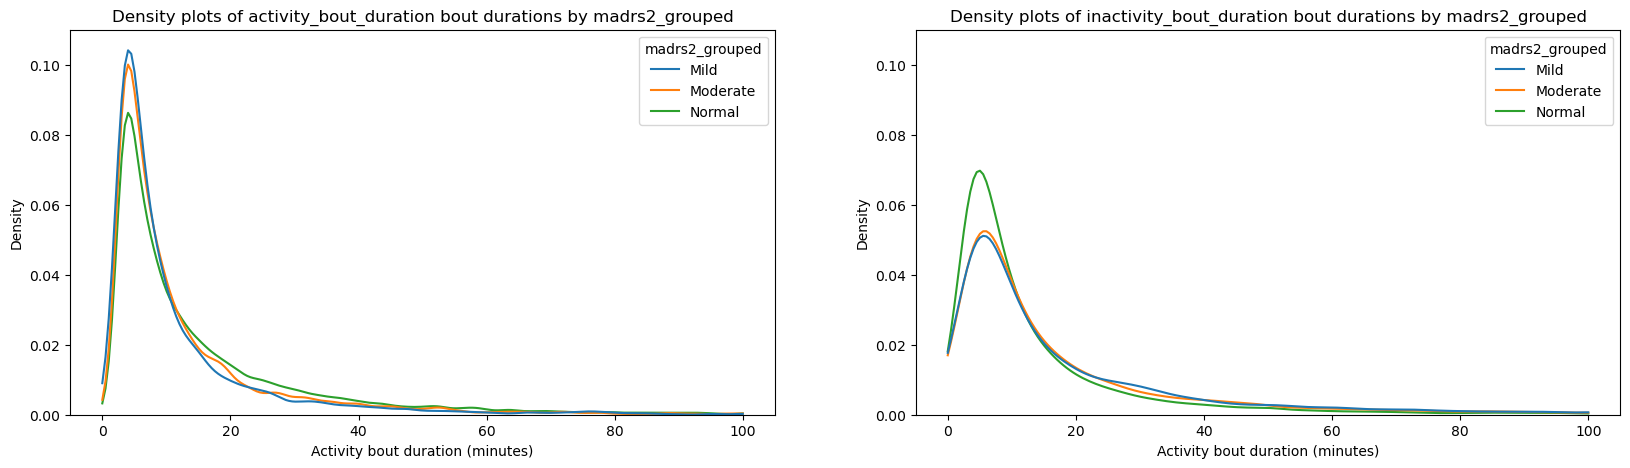

In [31]:
def plot_bout_durations(data, xcol, ax):
    """Plot density plots of bout durations by madrs2_grouped"""
    sns.kdeplot(
        data=data,
        x=xcol,
        hue='madrs2_grouped',
        bw_adjust=0.2,
        clip=(0, 100),
        common_norm=False,
        ax=ax
    )
    ax.set_title(f'Density plots of {xcol} bout durations by madrs2_grouped')
    ax.set_xlabel('Activity bout duration (minutes)')
    ax.set_ylabel('Density')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
plot_bout_durations(df_activity_bouts, xcol='activity_bout_duration', ax=ax1)
plot_bout_durations(df_inactivity_bouts, xcol='inactivity_bout_duration', ax=ax2)
ax1.set_ylim(0, 0.11)
ax2.set_ylim(0, 0.11)
fig.show()

From the above it looks like the kurtosis and skew may be different between the normal vs. depressed patients. Depressed patients seem to have shorter active bout durations and longer inactive bout durations

In [32]:
def calculate_bout_features(df_activity_bouts, df_inactivity_bouts):
    """
    Group data by number and calculate bout-based features for each number
    """

    # For each number, calculate the mean duration of activity and inactivity bout durations
    act_bout_dur_mean = df_activity_bouts.groupby('number')['activity_bout_duration'].mean()
    inact_bout_dur_mean = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].mean()

    # Standard deviation of activity and inactivity bout durations
    act_bout_dur_std = df_activity_bouts.groupby('number')['activity_bout_duration'].std()
    inact_bout_dur_std = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].std()

    # Coefficient of variation of activity and inactivity bout durations
    act_bout_dur_cv = act_bout_dur_std / act_bout_dur_mean
    inact_bout_dur_cv = inact_bout_dur_std / inact_bout_dur_mean
    
    # Kurtosis of activity and inactivity bouts
    act_bout_dur_kurtosis = df_activity_bouts.groupby('number')['activity_bout_duration'].apply(pd.DataFrame.kurtosis)
    inact_bout_dur_kurtosis = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(pd.DataFrame.kurtosis)

    # Skewness of activity and inactivity bouts
    act_bout_dur_skew = df_activity_bouts.groupby('number')['activity_bout_duration'].apply(pd.DataFrame.skew)
    inact_bout_dur_skew = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(pd.DataFrame.skew)

    # Entropy of activity and inactivity bouts
    act_bout_dur_entropy = df_activity_bouts.groupby('number')['activity_bout_duration'].apply(stats.entropy)
    inact_bout_dur_entropy = df_inactivity_bouts.groupby('number')['inactivity_bout_duration'].apply(stats.entropy)

    # Number of bouts of activity and inactivity per day
    act_bout_num = df_activity_bouts.groupby('number')['activity_bout_num'].count() / df_merged.groupby('number')['day_after_first'].max()
    inact_bout_num = df_inactivity_bouts.groupby('number')['inactivity_bout_num'].count() / df_merged.groupby('number')['day_after_first'].max()

    # Create new DataFrame with columns 'number', 'activity_bouts' and 'inactivity_bouts'
    df_bout_features = pd.DataFrame({'number':act_bout_dur_mean.index,
                                    'act_bout_num':act_bout_num.values,
                                    'act_bout_dur_mean':act_bout_dur_mean.values,
                                    'act_bout_dur_std':act_bout_dur_std.values,
                                    'act_bout_dur_cv':act_bout_dur_cv.values,
                                    'act_bout_dur_kurtosis': act_bout_dur_kurtosis.values,
                                    'act_bout_dur_skew': act_bout_dur_skew.values,
                                    'act_bout_dur_entropy': act_bout_dur_entropy.values,
                                    'inact_bout_num':inact_bout_num.values,
                                    'inact_bout_dur_mean':inact_bout_dur_mean.values,
                                    'inact_bout_dur_std':inact_bout_dur_std.values,
                                    'inact_bout_dur_cv':inact_bout_dur_cv.values,
                                    'inact_bout_dur_kurtosis': inact_bout_dur_kurtosis.values,
                                    'inact_bout_dur_skew': inact_bout_dur_skew.values,
                                    'inact_bout_dur_entropy': inact_bout_dur_entropy.values                                
                                    })
    
    # Add MADRS2_grouped column to df_bout_features
    df_bout_features = pd.merge(df_bout_features, df_merged[['number', 'madrs2_grouped']], on=['number'])

    # Remove duplicates
    df_bout_features = df_bout_features.drop_duplicates(subset=['number'])
    
    return df_bout_features

df_bout_features = calculate_bout_features(df_activity_bouts, df_inactivity_bouts)
df_bout_features.head()

number  act_bout_num  act_bout_dur_mean  act_bout_dur_std  \
0       condition_1     33.000000          13.479339         66.599417   
17279  condition_10     27.222222          25.906122         44.416750   
31678  condition_11     23.571429          10.981818          9.170107   
53277  condition_12     33.000000          11.515152         12.516208   
71996  condition_13     41.928571          13.521295         15.757683   

       act_bout_dur_cv  act_bout_dur_kurtosis  act_bout_dur_skew  \
0             4.940852             339.489631          18.155197   
17279         1.714527              85.683556           7.763403   
31678         0.835026               3.195085           1.772614   
53277         1.086934              14.890979           3.300979   
71996         1.165398              15.601526           3.217821   

       act_bout_dur_entropy  inact_bout_num  inact_bout_dur_mean  \
0                  4.664714       35.545455            30.368286   
17279              4.841926       20.333333            38.792350   
31678              5.514034       25.857143            45.690608   
53277              5.592052       36.250000            28.011494   
71996              5.918785       35.071429            25.356415   

       inact_bout_dur_std  inact_bout_dur_cv  inact_bout_dur_kurtosis  \
0               78.551779           2.586638                26.283712   
17279           85.684641           2.208803                12.928130   
31678          112.844307           2.469748                22.338060   
53277           62.078420           2.216177                19.911087   
71996           79.032060           3.116847               163.692901   

       inact_bout_dur_skew  inact_bout_dur_entropy madrs2_grouped  
0                 5.029551                4.747316           Mild  
17279             3.599703                4.043482       Moderate  
31678             4.516316                4.637721       Moderate  
53277             4.359810                5.026175       Moderate  
71996            10.843546                4.908043           Mild

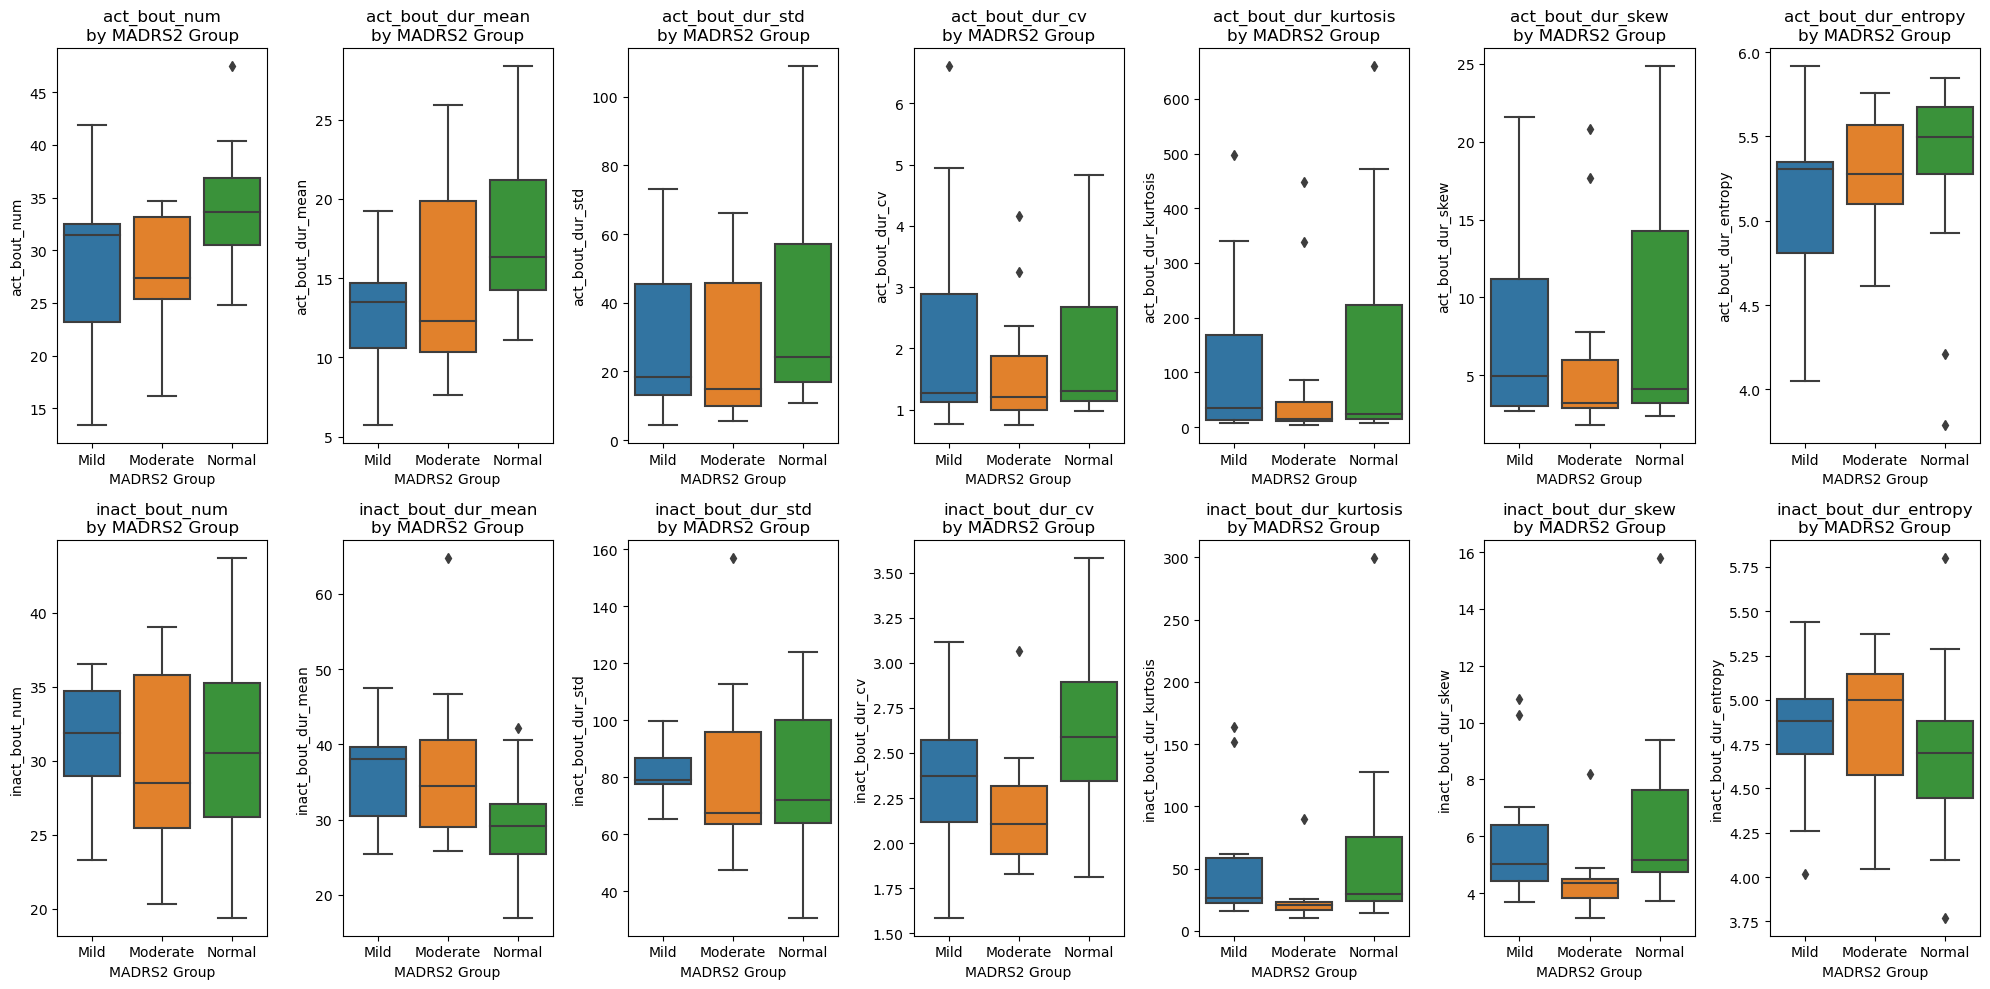

In [26]:
plot_features(data = df_bout_features, rows=2, cols=7, features=['act_bout_num',
                                                                'act_bout_dur_mean',
                                                                'act_bout_dur_std',
                                                                'act_bout_dur_cv',
                                                                'act_bout_dur_kurtosis',
                                                                'act_bout_dur_skew',
                                                                'act_bout_dur_entropy',
                                                                'inact_bout_num',
                                                                'inact_bout_dur_mean',
                                                                'inact_bout_dur_std',
                                                                'inact_bout_dur_cv',
                                                                'inact_bout_dur_kurtosis',
                                                                'inact_bout_dur_skew',
                                                                'inact_bout_dur_entropy'])


### Merge all the features together into a single dataframe

In [33]:
# Merge df_bout_features with df, dropping 'madrs2_grouped from df_bout_features'
df_features = pd.merge(df_activity_features, df_bout_features.drop('madrs2_grouped', axis=1), on=['number'])
df_features.head()

number madrs2_grouped  madrs2_grouped_ord  Normal  Mild  Moderate  \
0   condition_1           Mild                   1       0     1         0   
1  condition_10       Moderate                   2       0     0         1   
2  condition_11       Moderate                   2       0     0         1   
3  condition_12       Moderate                   2       0     0         1   
4  condition_13           Mild                   1       0     1         0   

   activity_interday_stability  activity_intraday_variability  activity_mean  \
0                     0.208737                     429.453604     155.345969   
1                     0.272192                     580.711403     321.150497   
2                     0.100964                     542.382958     132.735775   
3                     0.182716                     433.170487     174.285592   
4                     0.150851                     487.534039     262.156813   

   activity_mean_weekdays_0to6  ...  act_bout_dur_kurtosis  act_bout_dur_skew  \
0                    13.887798  ...             339.489631          18.155197   
1                    20.453869  ...              85.683556           7.763403   
2                    23.998701  ...               3.195085           1.772614   
3                    24.438095  ...              14.890979           3.300979   
4                    86.758009  ...              15.601526           3.217821   

   act_bout_dur_entropy  inact_bout_num  inact_bout_dur_mean  \
0              4.664714       35.545455            30.368286   
1              4.841926       20.333333            38.792350   
2              5.514034       25.857143            45.690608   
3              5.592052       36.250000            28.011494   
4              5.918785       35.071429            25.356415   

   inact_bout_dur_std  inact_bout_dur_cv  inact_bout_dur_kurtosis  \
0           78.551779           2.586638                26.283712   
1           85.684641           2.208803                12.928130   
2          112.844307           2.469748                22.338060   
3           62.078420           2.216177                19.911087   
4           79.032060           3.116847               163.692901   

   inact_bout_dur_skew  inact_bout_dur_entropy  
0             5.029551                4.747316  
1             3.599703                4.043482  
2             4.516316                4.637721  
3             4.359810                5.026175  
4            10.843546                4.908043  

[5 rows x 51 columns]

### Plot correlation heatmaps and drop redundant features

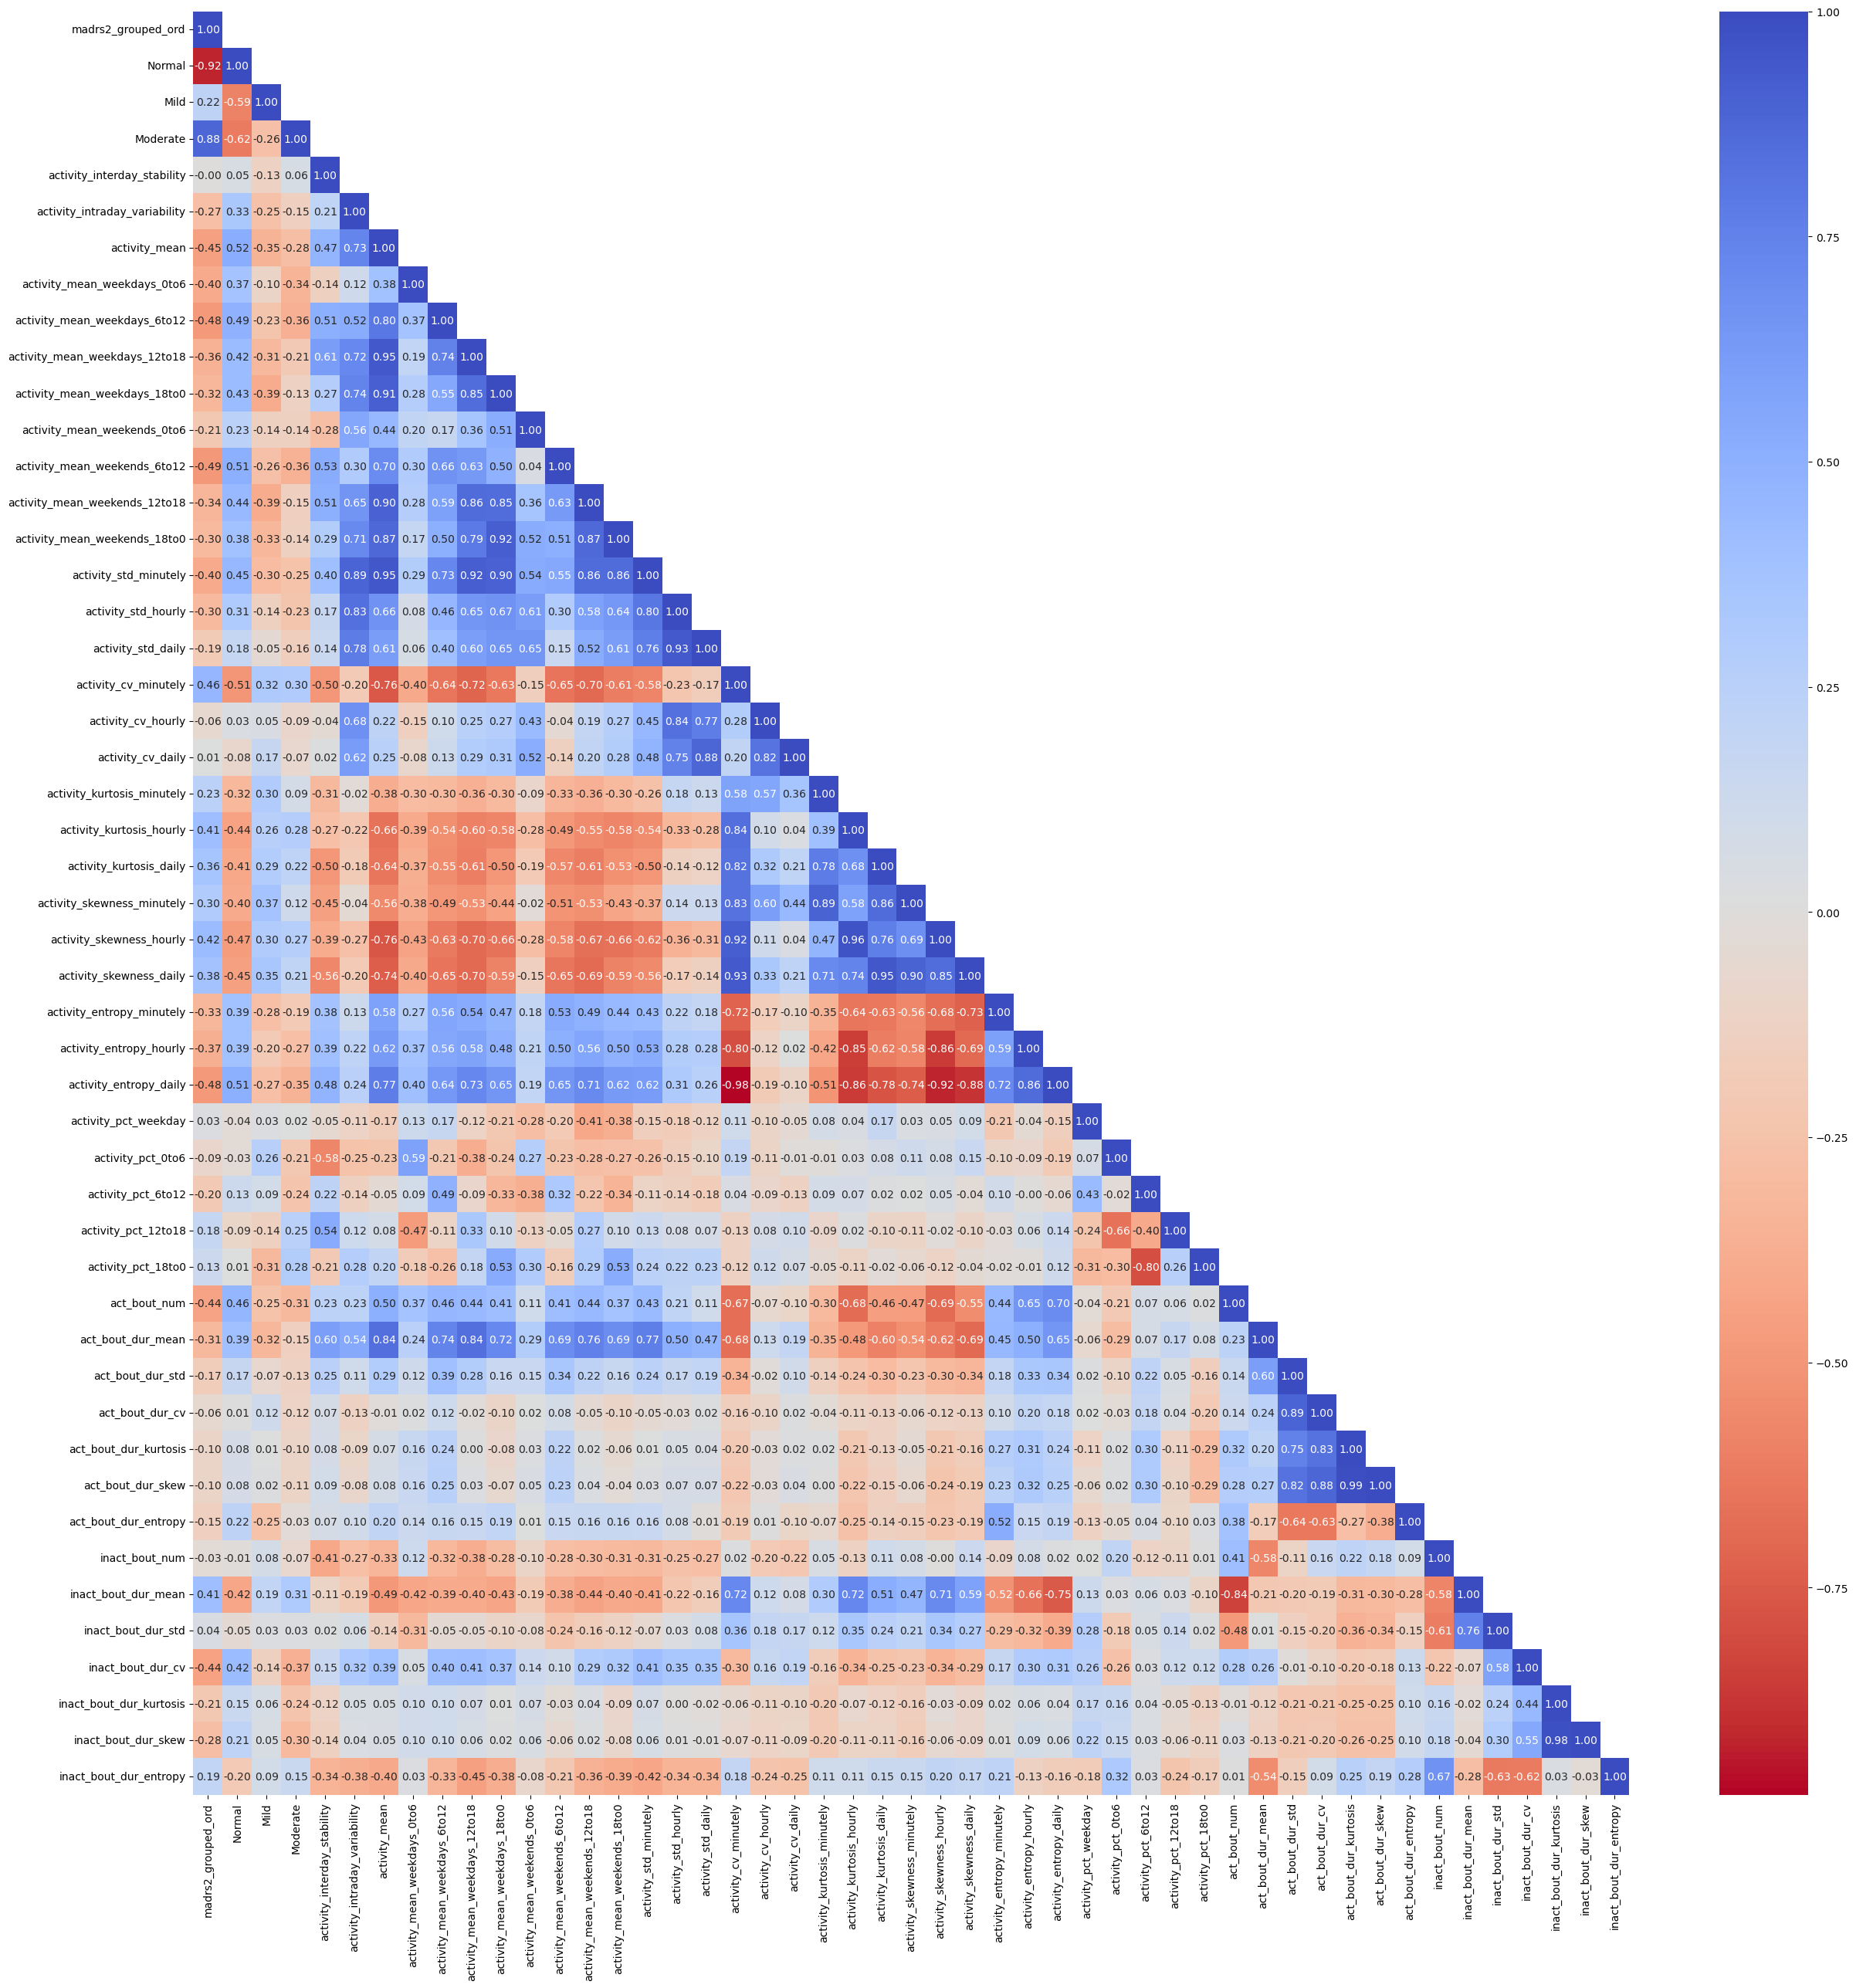

In [34]:
# Plot correlation heatmap
def plot_feature_correlation(data, cols_to_drop=['number', 'madrs2_grouped'], figsize=(30, 30)):
    """Plot a correlation heatmap of features with two significant figures"""
    data = data.drop(cols_to_drop, axis=1)   
    plt.figure(figsize=figsize)
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm_r', fmt='.2f', mask=np.triu(data.corr(), k=1))

plot_feature_correlation(df_features)

Some features should be dropped:
- activity_interday_stability (low correlation)
- pct_weekday activity (low correlation w/ madrs2_grouped)
- mean_activity (by day of week and time) as these are naturally highly correlated with overall mean_activity. pct_activity (by hour) is more correlated with depression
- standard deviations and coefficients of variation for activity values due to redundancies with other metrics
- keep skew values but remove kurtosis due to correlation between the two
- keep only _hourly values for skew and entropy of activity
- inact_bout_dur_std (low correlation)

These features could potentially be dropped:
- act_bout_dur_cv
- inact_bout_num

In [35]:
# Drop redundant features
df_features = df_features.drop(['activity_interday_stability',
                                'activity_mean_weekdays_0to6',
                                'activity_mean_weekdays_6to12',
                                'activity_mean_weekdays_12to18',
                                'activity_mean_weekdays_18to0',
                                'activity_mean_weekends_0to6',
                                'activity_mean_weekends_6to12',
                                'activity_mean_weekends_12to18',
                                'activity_mean_weekends_18to0',
                                'activity_std_minutely',
                                'activity_std_hourly',
                                'activity_std_daily',
                                'activity_cv_hourly',
                                'activity_cv_daily',
                                'activity_kurtosis_minutely',
                                'activity_kurtosis_hourly',
                                'activity_kurtosis_daily',
                                'activity_skewness_minutely',
                                'activity_skewness_daily',
                                'activity_entropy_minutely',
                                'activity_entropy_daily',
                                'activity_pct_weekday',
                                'act_bout_dur_kurtosis',
                                'inact_bout_num',
                                'inact_bout_dur_kurtosis',
                                'inact_bout_dur_std'
                                ], axis=1)

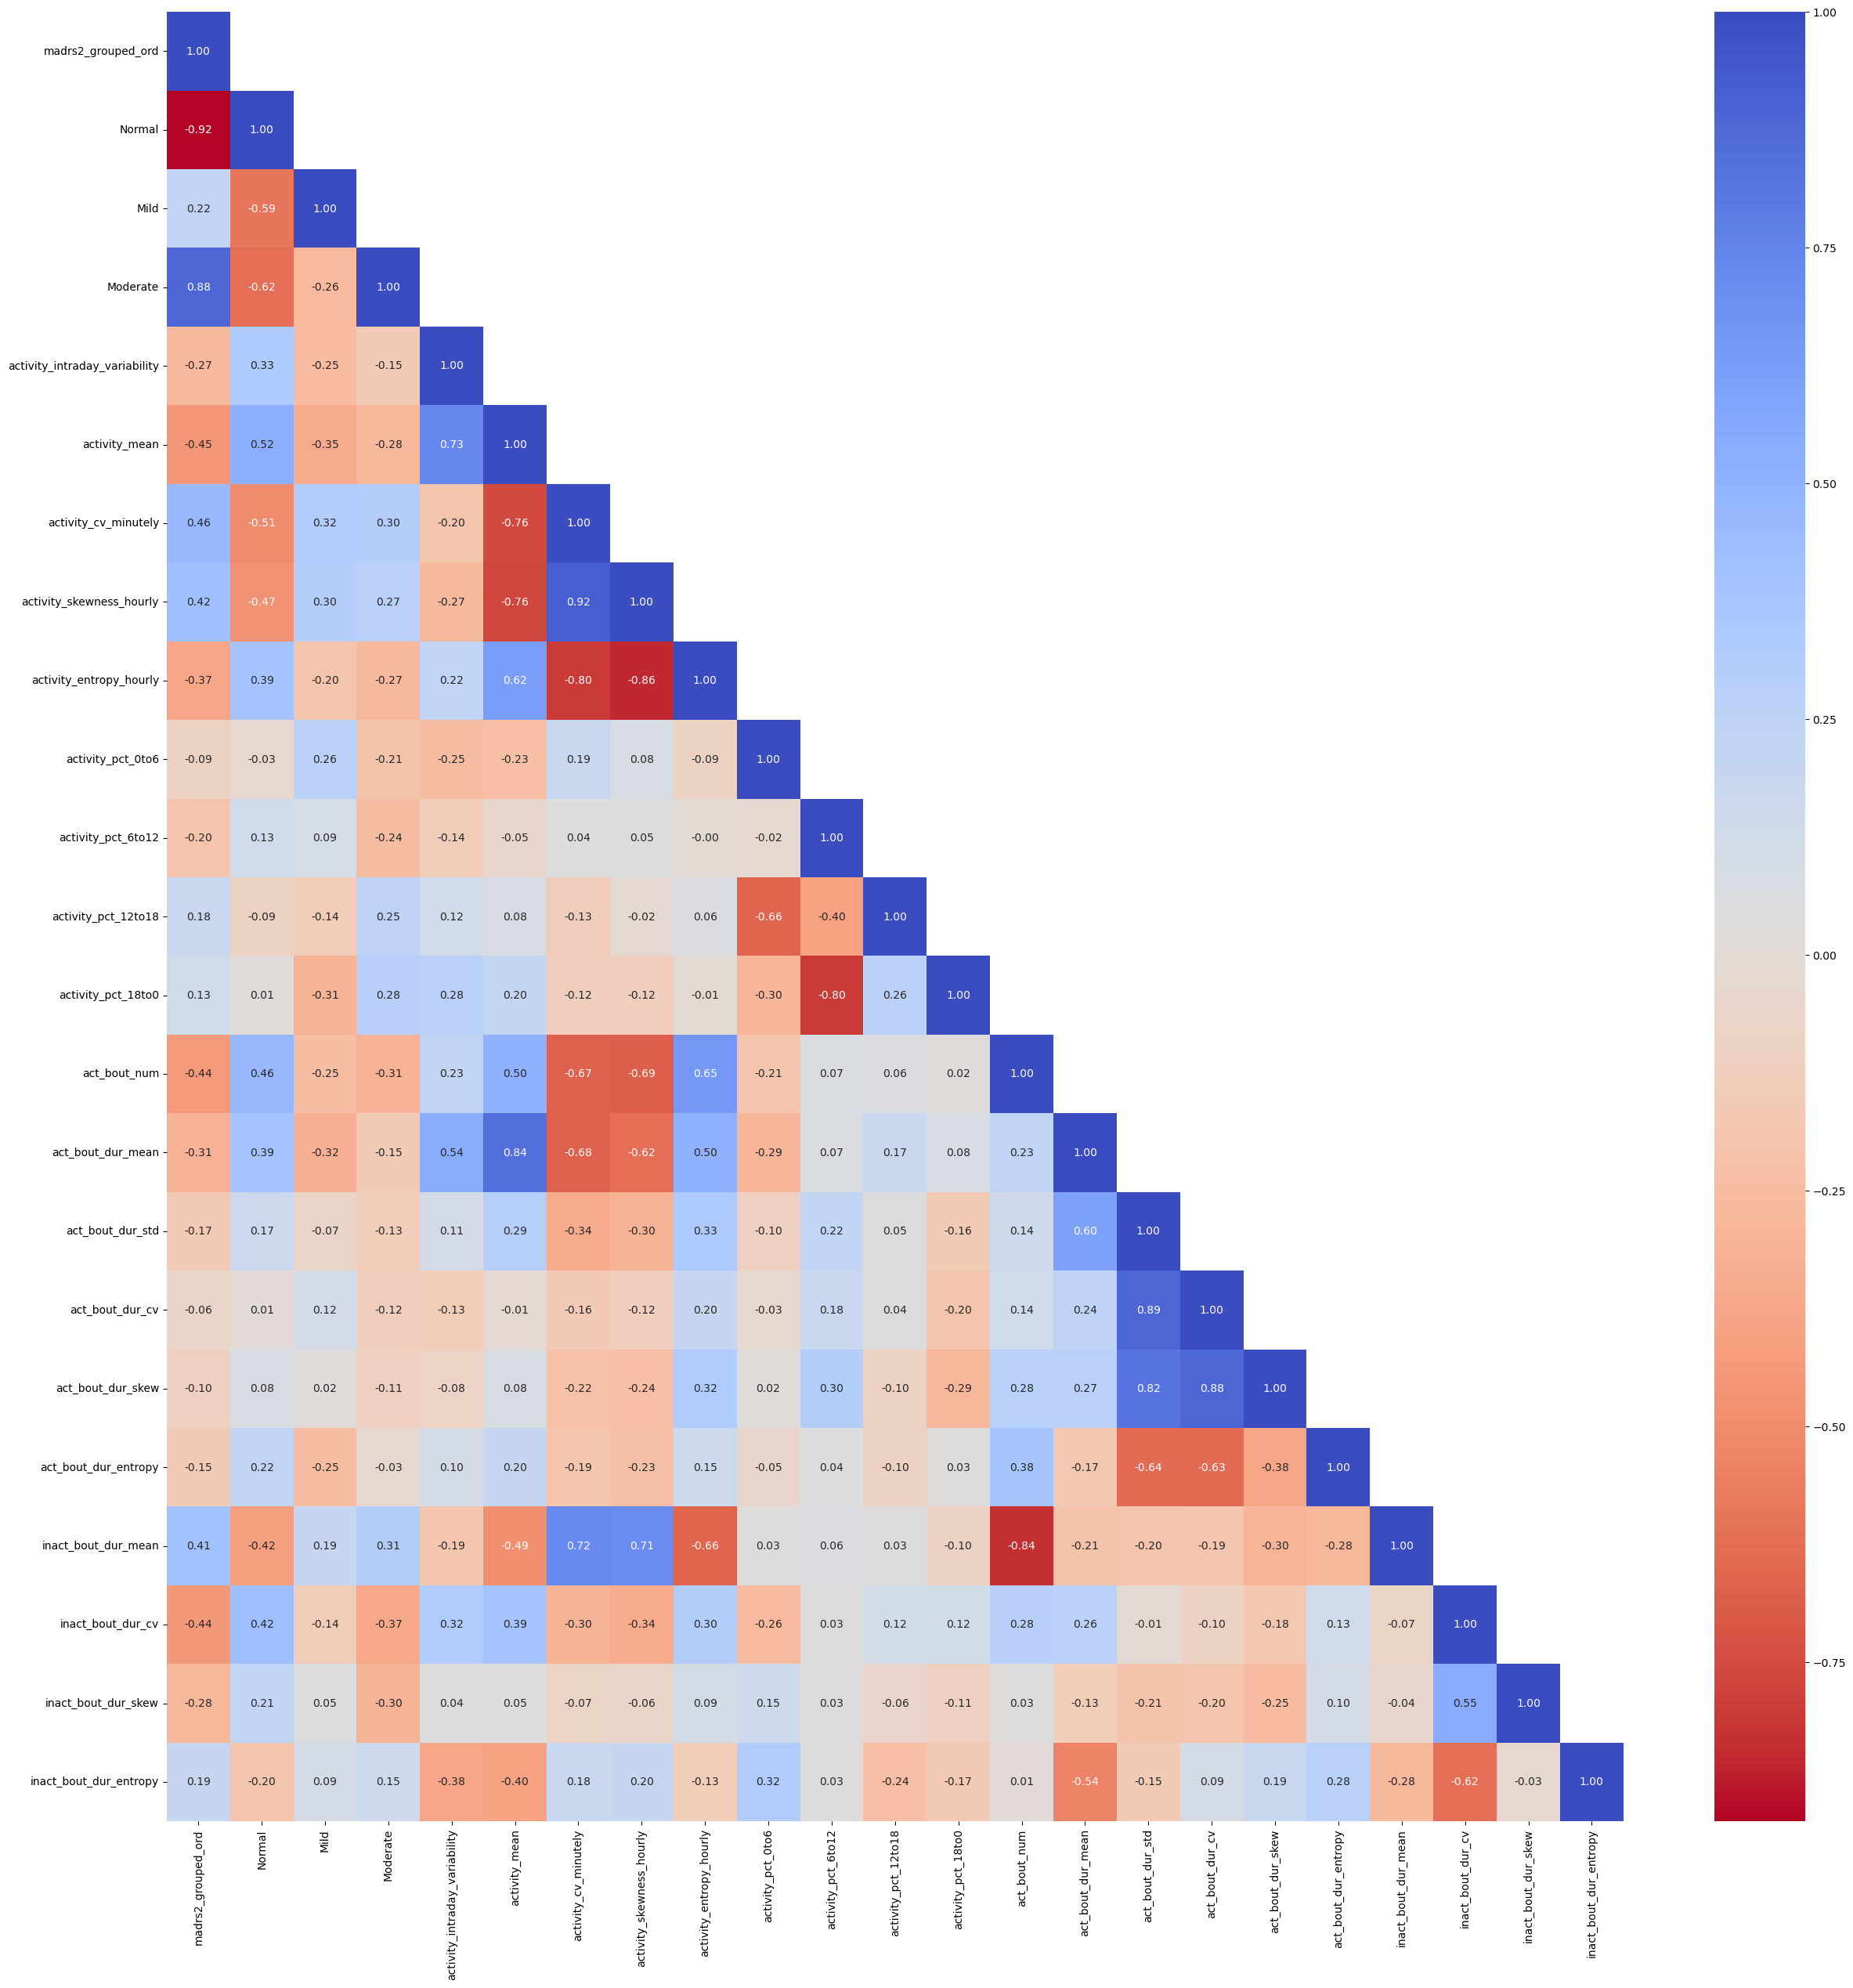

In [31]:
plot_feature_correlation(df_features)

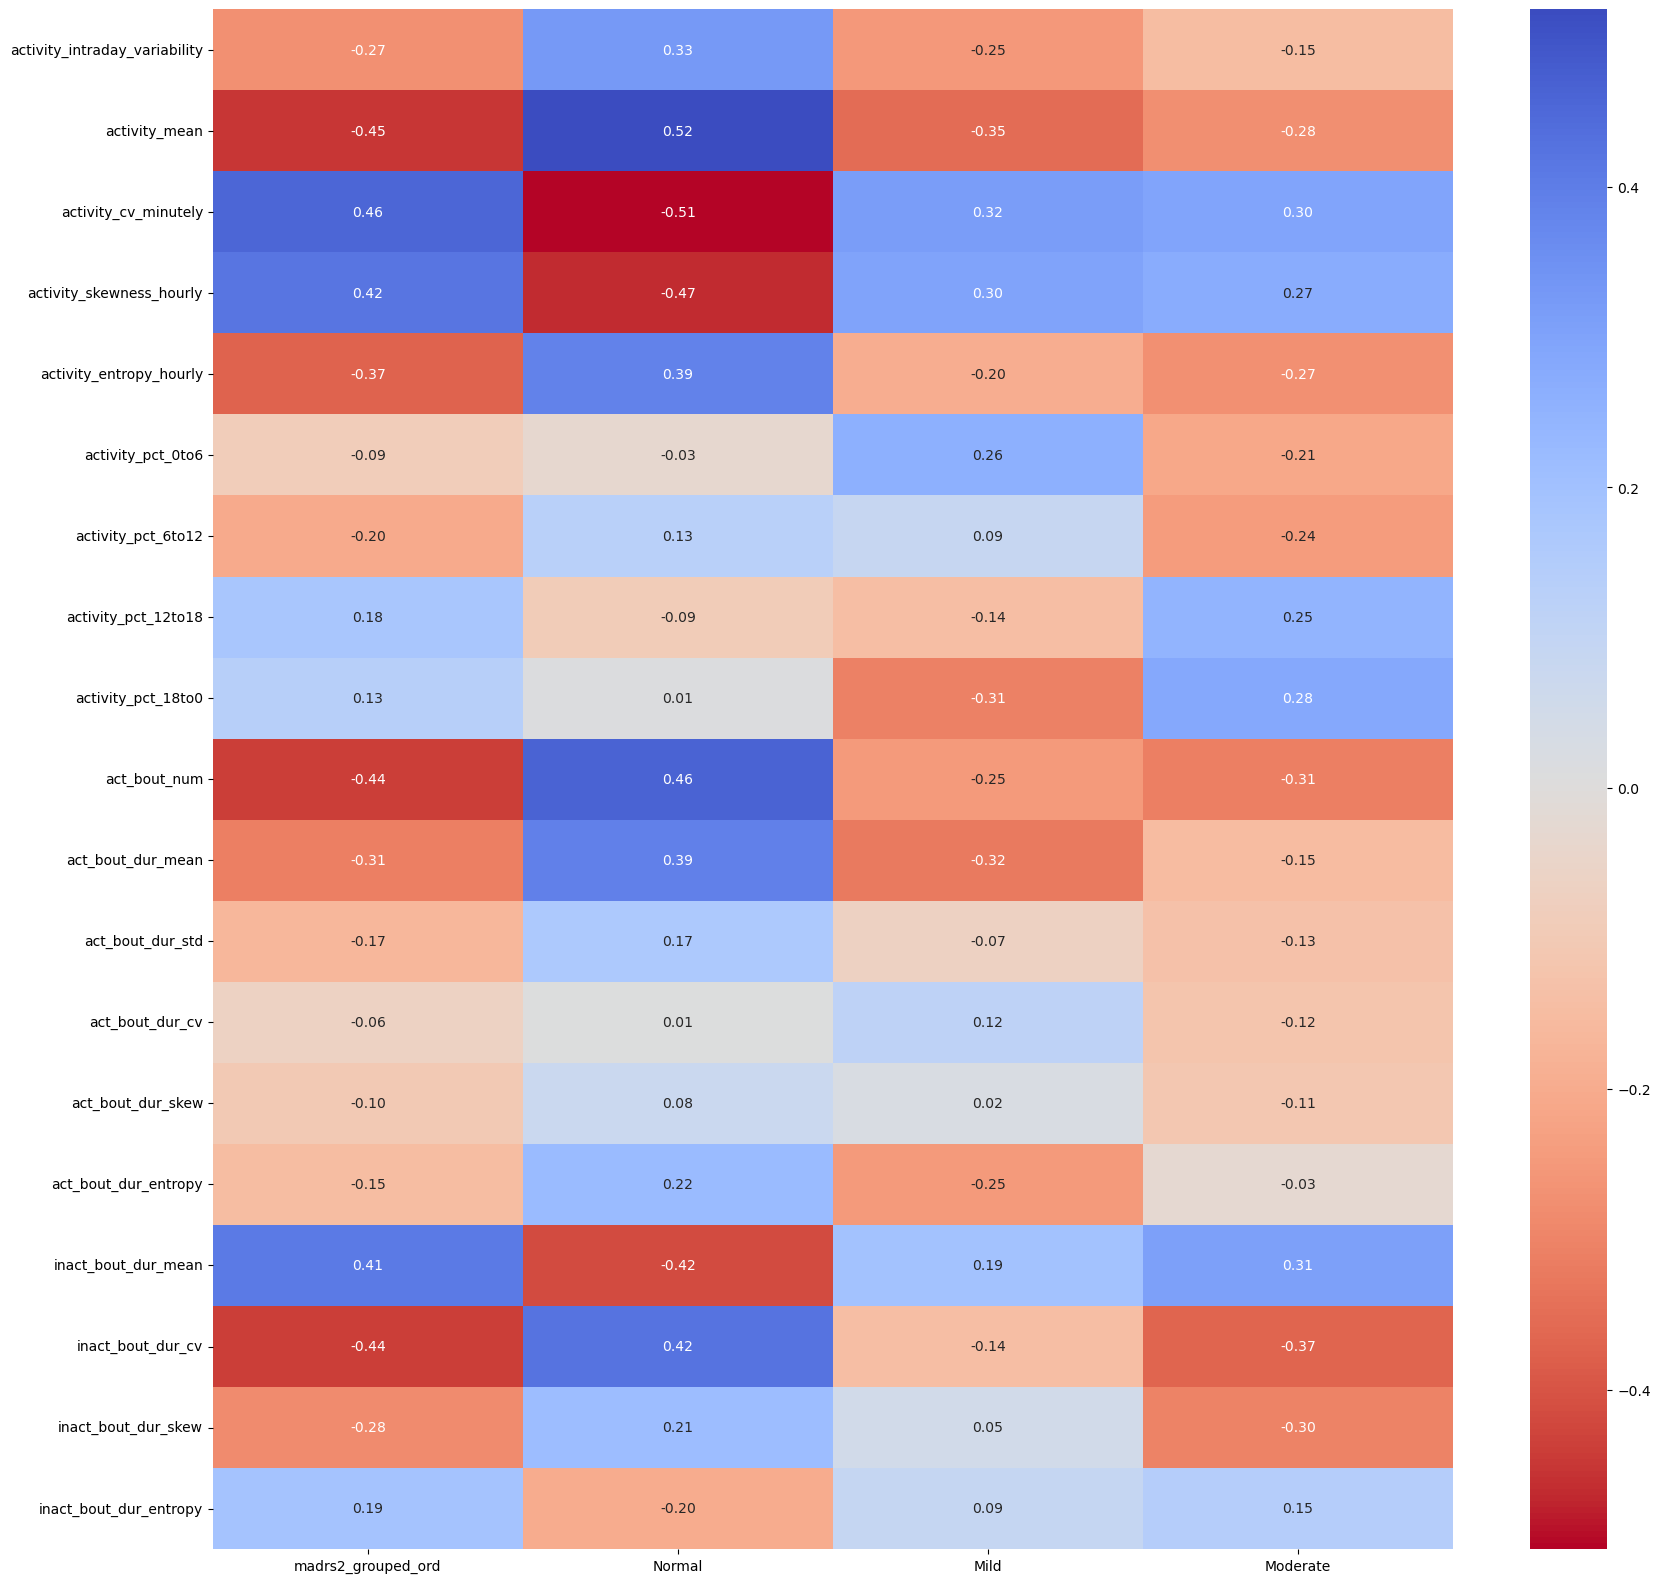

In [32]:
def plot_feature_correlation_simple(data, cols_to_drop=['number', 'madrs2_grouped'], figsize=(20, 20)):
    """Plot a correlation heatmap of features only showing correlation vs. madrs2 groups"""
    data = data.drop(cols_to_drop, axis=1)   
    plt.figure(figsize=figsize)
    sns.heatmap(data.corr().iloc[4:, :4], annot=True, cmap='coolwarm_r', fmt='.2f')

plot_feature_correlation_simple(df_features)

In [36]:
df_features

number madrs2_grouped  madrs2_grouped_ord  Normal  Mild  Moderate  \
0    condition_1           Mild                   1       0     1         0   
1   condition_10       Moderate                   2       0     0         1   
2   condition_11       Moderate                   2       0     0         1   
3   condition_12       Moderate                   2       0     0         1   
4   condition_13           Mild                   1       0     1         0   
5   condition_14           Mild                   1       0     1         0   
6   condition_15           Mild                   1       0     1         0   
7   condition_16           Mild                   1       0     1         0   
8   condition_17           Mild                   1       0     1         0   
9   condition_18           Mild                   1       0     1         0   
10  condition_19       Moderate                   2       0     0         1   
11   condition_2           Mild                   1       0     1         0   
12  condition_20       Moderate                   2       0     0         1   
13  condition_21       Moderate                   2       0     0         1   
14  condition_22       Moderate                   2       0     0         1   
15  condition_23       Moderate                   2       0     0         1   
16   condition_3       Moderate                   2       0     0         1   
17   condition_4           Mild                   1       0     1         0   
18   condition_5       Moderate                   2       0     0         1   
19   condition_6           Mild                   1       0     1         0   
20   condition_7       Moderate                   2       0     0         1   
21   condition_8           Mild                   1       0     1         0   
22   condition_9       Moderate                   2       0     0         1   
23     control_1         Normal                   0       1     0         0   
24    control_10         Normal                   0       1     0         0   
25    control_11         Normal                   0       1     0         0   
26    control_12         Normal                   0       1     0         0   
27    control_13         Normal                   0       1     0         0   
28    control_14         Normal                   0       1     0         0   
29    control_15         Normal                   0       1     0         0   
30    control_16         Normal                   0       1     0         0   
31    control_17         Normal                   0       1     0         0   
32    control_18         Normal                   0       1     0         0   
33    control_19         Normal                   0       1     0         0   
34     control_2         Normal                   0       1     0         0   
35    control_20         Normal                   0       1     0         0   
36    control_21         Normal                   0       1     0         0   
37    control_22         Normal                   0       1     0         0   
38    control_23         Normal                   0       1     0         0   
39    control_24         Normal                   0       1     0         0   
40    control_25         Normal                   0       1     0         0   
41    control_26         Normal                   0       1     0         0   
42    control_27         Normal                   0       1     0         0   
43    control_28         Normal                   0       1     0         0   
44    control_29         Normal                   0       1     0         0   
45     control_3         Normal                   0       1     0         0   
46    control_30         Normal                   0       1     0         0   
47    control_31         Normal                   0       1     0         0   
48    control_32         Normal                   0       1     0         0   
49     control_4         Normal                   0       1 

In [38]:
#extract indices
indices = np.arange(df_features.shape[0])
#shuffle indices
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)
#reindex the shuffle indices
df_features = df_features.reindex(shuffled_indices)
display(df_features)

number madrs2_grouped  madrs2_grouped_ord  Normal  Mild  Moderate  \
45     control_3         Normal                   0       1     0         0   
33    control_19         Normal                   0       1     0         0   
40    control_25         Normal                   0       1     0         0   
26    control_12         Normal                   0       1     0         0   
11   condition_2           Mild                   1       0     1         0   
2   condition_11       Moderate                   2       0     0         1   
32    control_18         Normal                   0       1     0         0   
43    control_28         Normal                   0       1     0         0   
46    control_30         Normal                   0       1     0         0   
30    control_16         Normal                   0       1     0         0   
4   condition_13           Mild                   1       0     1         0   
10  condition_19       Moderate                   2       0     0         1   
28    control_14         Normal                   0       1     0         0   
22   condition_9       Moderate                   2       0     0         1   
31    control_17         Normal                   0       1     0         0   
49     control_4         Normal                   0       1     0         0   
37    control_22         Normal                   0       1     0         0   
7   condition_16           Mild                   1       0     1         0   
14  condition_22       Moderate                   2       0     0         1   
27    control_13         Normal                   0       1     0         0   
35    control_20         Normal                   0       1     0         0   
50     control_5         Normal                   0       1     0         0   
18   condition_5       Moderate                   2       0     0         1   
52     control_7         Normal                   0       1     0         0   
34     control_2         Normal                   0       1     0         0   
15  condition_23       Moderate                   2       0     0         1   
5   condition_14           Mild                   1       0     1         0   
29    control_15         Normal                   0       1     0         0   
16   condition_3       Moderate                   2       0     0         1   
53     control_8         Normal                   0       1     0         0   
20   condition_7       Moderate                   2       0     0         1   
48    control_32         Normal                   0       1     0         0   
8   condition_17           Mild                   1       0     1         0   
13  condition_21       Moderate                   2       0     0         1   
25    control_11         Normal                   0       1     0         0   
17   condition_4           Mild                   1       0     1         0   
41    control_26         Normal                   0       1     0         0   
54     control_9         Normal                   0       1     0         0   
38    control_23         Normal                   0       1     0         0   
1   condition_10       Moderate                   2       0     0         1   
12  condition_20       Moderate                   2       0     0         1   
42    control_27         Normal                   0       1     0         0   
24    control_10         Normal                   0       1     0         0   
6   condition_15           Mild                   1       0     1         0   
23     control_1         Normal                   0       1     0         0   
36    control_21         Normal                   0       1     0         0   
21   condition_8           Mild                   1       0     1         0   
19   condition_6           Mild                   1       0     1         0   
9   condition_18           Mild                   1       0     1         0   
39    control_24         Normal                   0       1 

In [48]:
#drop unnecesarry column
df_depression = df_features.drop(['number',
                  'madrs2_grouped_ord',
                  'Normal',
                  'Mild',
                  'Moderate'
                  ], axis=1)
df_depression.head(5)


madrs2_grouped  activity_intraday_variability  activity_mean  \
45         Normal                     450.847169     251.233880   
33         Normal                     497.025070     226.506920   
40         Normal                     578.504177     316.378243   
26         Normal                     341.117566     147.202370   
11           Mild                     566.183307     211.694251   

    activity_cv_minutely  activity_skewness_hourly  activity_entropy_hourly  \
45              1.409631                  2.460635                 2.983348   
33              1.504780                  2.512661                 2.879155   
40              1.353900                  2.450694                 2.934241   
26              1.597837                  2.697773                 2.747899   
11              1.773271                  2.791286                 3.289624   

    activity_pct_0to6  activity_pct_6to12  activity_pct_12to18  \
45           0.054177            0.330761             0.467835   
33           0.143689            0.312672             0.472337   
40           0.089373            0.405664             0.427227   
26           0.065251            0.393316             0.488679   
11           0.121124            0.610582             0.366612   

    activity_pct_18to0  act_bout_num  act_bout_dur_mean  act_bout_dur_std  \
45            0.292114     36.666667          16.975000         17.689084   
33            0.267625     36.384615          13.955603         15.838704   
40            0.257936     30.461538          25.111111         75.382117   
26            0.238847     28.285714          12.378788         14.921837   
11            0.064197     32.055556          15.303293         61.551835   

    act_bout_dur_cv  act_bout_dur_skew  act_bout_dur_entropy  \
45         1.042067           2.667753              5.687968   
33         1.134935           3.636279              5.738435   
40         3.001943          16.823950              5.101094   
26         1.205436           4.124580              5.541758   
11         4.022130          21.570781              5.341824   

    inact_bout_dur_mean  inact_bout_dur_cv  inact_bout_dur_skew  \
45            31.866667           3.549919             7.853831   
33            28.545679           2.372276             4.508271   
40            29.782738           2.313598             4.512948   
26            36.585082           2.519433             9.393374   
11            34.537698           2.350872             4.200135   

    inact_bout_dur_entropy  
45                4.095484  
33                4.832628  
40                4.707541  
26                4.984534  
11                4.979392

In [61]:
mapping = {'Normal': 0, 'Mild': 1, 'Moderate': 2}
df_depression = df_depression.replace({'madrs2_grouped':mapping})
df_depression.head(5)

madrs2_grouped  activity_intraday_variability  activity_mean  \
45               0                     450.847169     251.233880   
33               0                     497.025070     226.506920   
40               0                     578.504177     316.378243   
26               0                     341.117566     147.202370   
11               1                     566.183307     211.694251   

    activity_cv_minutely  activity_skewness_hourly  activity_entropy_hourly  \
45              1.409631                  2.460635                 2.983348   
33              1.504780                  2.512661                 2.879155   
40              1.353900                  2.450694                 2.934241   
26              1.597837                  2.697773                 2.747899   
11              1.773271                  2.791286                 3.289624   

    activity_pct_0to6  activity_pct_6to12  activity_pct_12to18  \
45           0.054177            0.330761             0.467835   
33           0.143689            0.312672             0.472337   
40           0.089373            0.405664             0.427227   
26           0.065251            0.393316             0.488679   
11           0.121124            0.610582             0.366612   

    activity_pct_18to0  act_bout_num  act_bout_dur_mean  act_bout_dur_std  \
45            0.292114     36.666667          16.975000         17.689084   
33            0.267625     36.384615          13.955603         15.838704   
40            0.257936     30.461538          25.111111         75.382117   
26            0.238847     28.285714          12.378788         14.921837   
11            0.064197     32.055556          15.303293         61.551835   

    act_bout_dur_cv  act_bout_dur_skew  act_bout_dur_entropy  \
45         1.042067           2.667753              5.687968   
33         1.134935           3.636279              5.738435   
40         3.001943          16.823950              5.101094   
26         1.205436           4.124580              5.541758   
11         4.022130          21.570781              5.341824   

    inact_bout_dur_mean  inact_bout_dur_cv  inact_bout_dur_skew  \
45            31.866667           3.549919             7.853831   
33            28.545679           2.372276             4.508271   
40            29.782738           2.313598             4.512948   
26            36.585082           2.519433             9.393374   
11            34.537698           2.350872             4.200135   

    inact_bout_dur_entropy  
45                4.095484  
33                4.832628  
40                4.707541  
26                4.984534  
11                4.979392

In [62]:
#split data
# Use a ~80/20 train/test split.
depression_train = df_depression[:44]
depression_test = df_depression[44:]

# Create separate variables for features (inputs) and labels (outputs).
# We will be using these in the cells below.
depression_train_features = depression_train.iloc[:,1:19]
depression_test_features = depression_test.iloc[:,1:19]
depression_train_labels = depression_train['madrs2_grouped']
depression_test_labels = depression_test['madrs2_grouped']

# Confirm the data shapes are as expected.
print('train data shape:', depression_train_features.shape)
print('train labels shape:', depression_train_labels.shape)
print('test data shape:', depression_test_features.shape)
print('test labels shape:', depression_test_labels.shape)

train data shape: (44, 18)
train labels shape: (44,)
test data shape: (11, 18)
test labels shape: (11,)


In [63]:
#normalize the features
depression_train_features_norm=(depression_train_features-depression_train_features.mean())/depression_train_features.std()
depression_test_features_norm = (depression_test_features-depression_train_features.mean())/depression_train_features.std()
depression_train_features_norm.describe()

activity_intraday_variability  activity_mean  activity_cv_minutely  \
count                   4.400000e+01   4.400000e+01          4.400000e+01   
mean                    7.670632e-16   2.018587e-16         -1.685520e-15   
std                     1.000000e+00   1.000000e+00          1.000000e+00   
min                    -2.205643e+00  -1.836772e+00         -1.254414e+00   
25%                    -6.185666e-01  -7.246755e-01         -6.877726e-01   
50%                     5.697318e-02   6.042662e-02         -2.428633e-01   
75%                     3.475334e-01   6.508705e-01          3.685923e-01   
max                     3.292389e+00   1.920180e+00          3.374635e+00   

       activity_skewness_hourly  activity_entropy_hourly  activity_pct_0to6  \
count              4.400000e+01             4.400000e+01       4.400000e+01   
mean               1.665335e-16             8.124814e-16       3.135118e-16   
std                1.000000e+00             1.000000e+00       1.000000e+00   
min               -1.417345e+00            -2.756002e+00      -1.370802e+00   
25%               -6.788509e-01            -4.463225e-01      -5.464322e-01   
50%               -2.387678e-01             1.647095e-01      -1.551890e-01   
75%                4.778338e-01             5.655358e-01       2.614724e-01   
max                2.964245e+00             1.705116e+00       4.973517e+00   

       activity_pct_6to12  activity_pct_12to18  activity_pct_18to0  \
count        4.400000e+01         4.400000e+01        4.400000e+01   
mean         2.807098e-16         6.131459e-16        1.980739e-16   
std          1.000000e+00         1.000000e+00        1.000000e+00   
min         -2.125901e+00        -3.737322e+00       -3.652952e+00   
25%         -5.452094e-01        -5.807914e-01       -3.158105e-01   
50%          9.809660e-02         5.148957e-02        1.369156e-01   
75%          3.192997e-01         5.391632e-01        5.226761e-01   
max          3.277892e+00         2.039387e+00        1.624083e+00   

       act_bout_num  act_bout_dur_mean  act_bout_dur_std  act_bout_dur_cv  \
count  4.400000e+01       4.400000e+01      4.400000e+01     4.400000e+01   
mean  -2.018587e-16       2.523234e-16      9.588290e-17     2.094284e-16   
std    1.000000e+00       1.000000e+00      1.000000e+00     1.000000e+00   
min   -2.365654e+00      -1.598750e+00     -1.124507e+00    -9.137082e-01   
25%   -6.269043e-01      -7.231118e-01     -7.708532e-01    -6.611370e-01   
50%    9.118729e-02      -2.680942e-01     -3.812904e-01    -5.281601e-01   
75%    5.573561e-01       6.659856e-01      8.853806e-01     5.067343e-01   
max    2.566183e+00       2.243558e+00      2.424947e+00     3.396010e+00   

       act_bout_dur_skew  act_bout_dur_entropy  inact_bout_dur_mean  \
count       4.400000e+01          4.400000e+01         4.400000e+01   
mean       -1.589638e-16         -2.184096e-15         7.796794e-16   
std         1.000000e+00          1.000000e+00         1.000000e+00   
min        -8.826662e-01         -3.358357e+00        -1.908133e+00   
25%        -6.991446e-01         -3.825350e-01        -7.375966e-01   
50%        -5.810008e-01         -5.484457e-03        -1.425839e-01   
75%         9.830034e-01          6.905076e-01         5.283048e-01   
max         2.334966e+00          1.458894e+00         3.753631e+00   

       inact_bout_dur_cv  inact_bout_dur_skew  
count       4.400000e+01         4.400000e+01  
mean        1.413011e-15         5.172630e-17  
std         1.000000e+00         1.000000e+00  
min        -2.014437e+00        -1.092523e+00  
25%        -5.414119e-01        -5.611493e-01  
50%        -1.036698e-01        -3.657251e-01  
75%         7.714195e-01         1.784548e-01  
max         2.282746e+00         4.156593e+00

In [64]:
def build_model(n_classes = 3, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      units=n_classes,
      use_bias=True,
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

In [96]:
model = build_model(3,0.01)

hist = model.fit(
  x = depression_train_features_norm,
  y = depression_train_labels,
  epochs=30,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(hist.history)
display(history)

Epoch 1/30
1/1 [==============================] - 0s 176ms/step - loss: 1.2874 - accuracy: 0.3590 - val_loss: 1.0291 - val_accuracy: 0.2000
Epoch 2/30
1/1 [==============================] - 0s 13ms/step - loss: 1.2237 - accuracy: 0.3846 - val_loss: 0.9456 - val_accuracy: 0.4000
Epoch 3/30
1/1 [==============================] - 0s 13ms/step - loss: 1.1654 - accuracy: 0.3846 - val_loss: 0.8753 - val_accuracy: 0.4000
Epoch 4/30
1/1 [==============================] - 0s 12ms/step - loss: 1.1127 - accuracy: 0.4359 - val_loss: 0.8175 - val_accuracy: 0.4000
Epoch 5/30
1/1 [==============================] - 0s 14ms/step - loss: 1.0653 - accuracy: 0.4103 - val_loss: 0.7706 - val_accuracy: 0.6000
Epoch 6/30
1/1 [==============================] - 0s 14ms/step - loss: 1.0228 - accuracy: 0.4103 - val_loss: 0.7328 - val_accuracy: 0.6000
Epoch 7/30
1/1 [==============================] - 0s 14ms/step - loss: 0.9847 - accuracy: 0.4103 - val_loss: 0.7028 - val_accuracy: 0.6000
Epoch 8/30
1/1 [==========

loss  accuracy  val_loss  val_accuracy
0   1.287449  0.358974  1.029124           0.2
1   1.223678  0.384615  0.945578           0.4
2   1.165417  0.384615  0.875292           0.4
3   1.112713  0.435897  0.817495           0.4
4   1.065317  0.410256  0.770571           0.6
5   1.022800  0.410256  0.732831           0.6
6   0.984730  0.410256  0.702816           0.6
7   0.950711  0.461538  0.679197           0.6
8   0.920372  0.487179  0.660749           0.6
9   0.893353  0.512821  0.646382           0.6
10  0.869312  0.512821  0.635157           0.6
11  0.847918  0.564103  0.626300           0.6
12  0.828864  0.564103  0.619196           0.6
13  0.811865  0.641026  0.613372           0.6
14  0.796657  0.641026  0.608473           0.6
15  0.783001  0.641026  0.604235           0.6
16  0.770683  0.666667  0.600465           0.6
17  0.759511  0.666667  0.597026           0.6
18  0.749319  0.692308  0.593822           0.6
19  0.739960  0.692308  0.590800           0.6
20  0.731309  0.717949  0.587933           0.6
21  0.723259  0.743590  0.585222           0.6
22  0.715721  0.743590  0.582683           0.6
23  0.708619  0.769231  0.580340           0.6
24  0.701891  0.769231  0.578226           0.6
25  0.695486  0.769231  0.576371           0.8
26  0.689363  0.769231  0.574800           0.8
27  0.683488  0.794872  0.573533           0.8
28  0.677835  0.794872  0.572578           0.8
29  0.672382  0.794872  0.571936           0.8

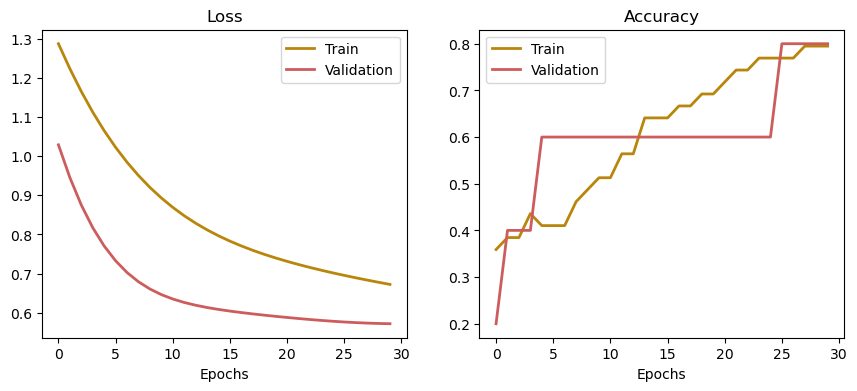

In [97]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');
